# 1. Motivation 

I have choosen to work with data related to global trade, with a specific focus on the development of USA and China. This was primarily motivated, by having to come up with an exciting project, around the time President Trump, was really spiking the traffis around the world, with a major focus on China. As such I thought it would be fun to see how China became the world leading export market, and how USA fell behind.

To then perform any sort of analysis on global trade, I looked at several different datasets but landed on a really nice dataset that could handle most of my exisiting ideas: [Correlates of War Project Trade Data Set](https://correlatesofwar.org/data-sets/bilateral-trade/) [1,2]. With this as my main dataset, I also augment it by using the [Maddison Project](https://ourworldindata.org/grapher/gdp-per-capita-maddison-project-database) [3], which is a simple database of the diachronic development of countries GPDs.

As a end goal for the user experience, I imagined simply walking the user through maybe 4-5 visulizations, showing different ways to represent that developments between countries, and how we could extract different narratives from this data.


**References:**

[1] Barbieri, Katherine and Omar M. G. Omar Keshk. 2016. Correlates of War Project Trade Data Set Codebook, Version 4.0. Online: https://correlatesofwar.org.

[2] Barbieri, Katherine, Omar M. G. Keshk, and Brian Pollins. 2009. "TRADING DATA: Evaluating our Assumptions and Coding Rules." Conflict Management and Peace Science. 26(5): 471-491.

[3] Max Roser, Bertha Rohenkohl, Pablo Arriagada, Joe Hasell, Hannah Ritchie, and Esteban Ortiz-Ospina (2023) - "Economic Growth". Data adapted from Bolt and van Zanden. Retrieved from https://ourworldindata.org/grapher/gdp-per-capita-maddison-project-database [online resource]

# 2. Basic stats

The authors of the dataset was nice enough to include a very detailed explanation of all their data and its behaviors. Noticeable, I decided I only really needed 7 of its 23 columns, as these contained the import and export between 2 countries, calculated in todays (2014s) american dollars, per year.

Columns of interest:
- ccode1
- ccode2
- year
- importer1
- importer2
- flow1
- flow2

Be aware that it could have been done with 2 less columns since ccodes are just numbers encoding country codes.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pathlib import Path
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
import wbdata
import warnings



In [19]:
warnings.filterwarnings('ignore')

df = pd.read_csv("datasets/Dyadic_COW_4.0.csv")
print(f"Shape of dataframe: {df.shape}")
print("\nFirst few rows of the dataframe:")
display(df.head())

Shape of dataframe: (886828, 23)

First few rows of the dataframe:


ccode1  ccode2  year                 importer1 importer2      flow1  \
0       2      20  1920  United States of America    Canada  611.85999   
1       2      20  1921  United States of America    Canada  335.44000   
2       2      20  1922  United States of America    Canada  364.01999   
3       2      20  1923  United States of America    Canada  416.00000   
4       2      20  1924  United States of America    Canada  399.14001   

       flow2  smoothflow1  smoothflow2  smoothtotrade  ...  dip2  trdspike  \
0  735.47998    611.85999    735.47998     1347.34000  ...     0         0   
1  442.98999    335.44000    442.98999      778.42999  ...     0         0   
2  502.84000    364.01999    502.84000      866.85999  ...     0         0   
3  598.14001    416.00000    598.14001     1014.14000  ...     0         0   
4  496.32001    399.14001    496.32001      895.46002  ...     0         0   

   tradedip  bel_lux_alt_flow1  bel_lux_alt_flow2  china_alt_flow1  \
0         0               -9.0               -9.0             -9.0   
1         0               -9.0               -9.0             -9.0   
2         0               -9.0               -9.0             -9.0   
3         0               -9.0               -9.0             -9.0   
4         0               -9.0               -9.0             -9.0   

   china_alt_flow2  source1  source2  version  
0             -9.0      1.0      1.0        4  
1             -9.0      1.0      1.0        4  
2             -9.0      1.0      1.0        4  
3             -9.0      1.0      1.0        4  
4             -9.0      1.0      1.0        4  

[5 rows x 23 columns]

In [20]:
indicators = {'NY.GDP.MKTP.KD': 'GDP'}
data = wbdata.get_dataframe(indicators) 
data

GDP
country                     date              
Africa Eastern and Southern 2024           NaN
                            2023  1.064487e+12
                            2022  1.040350e+12
                            2021  1.004646e+12
                            2020  9.606813e+11
...                                        ...
Zimbabwe                    1964  4.905391e+09
                            1963  4.960260e+09
                            1962  4.668729e+09
                            1961  4.602704e+09
                            1960  4.329261e+09

[17290 rows x 1 columns]

During initial EDA of the bi-lateral trade data, it was discovered that there were a lot of missing and/or faulty data. This however were aptly explained by the dataset authors by source codes, as well as specific values such as "-9" in the columns.

To better understand the behaviors of the data, I then first created the framework to clean the data, and show what I did to the data, to the end user. Personally I thought this would serve as a good introduction to end user, and to explain that the dataset wasnt perfect.

In [21]:
def clean_trade_data(df):
    """
    Analyze and clean trade data based on source codes from documentation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The raw trade data dataframe with source1 and source2 columns
    
    Returns:
    --------
    tuple
        (cleaned_df, quality_report)
        cleaned_df: The cleaned dataframe
        quality_report: Dictionary containing data quality metrics
    """
    # Initialize quality report
    quality_report = {
        'original_rows': len(df),
        'source_codes': {
            '-9': {'count': 0, 'description': 'Missing data'},
            '1': {'count': 0, 'description': 'Barbieri Version 1'},
            '2': {'count': 0, 'description': 'Hicks (2015) Imports'},
            '2.01': {'count': 0, 'description': 'Revised Hicks Imports'},
            '2.1': {'count': 0, 'description': "Hicks (2015) Exporter's report"},
            '2.11': {'count': 0, 'description': "Revised Hicks Exporter's report"},
            '3': {'count': 0, 'description': 'IMF import reports (2015)'},
            '4': {'count': 0, 'description': 'Missing imports replaced with IMF exports'},
            '5': {'count': 0, 'description': "Zero trade replaced with IMF's exports"},
            '6': {'count': 0, 'description': 'COW 4.0 replaced with COW 3.0'}
        },
        'yearly_stats': {},
        'cleaning_steps': [],
        'data_sources': {}
    }
    
    # Create a copy of the dataframe to clean
    cleaned_df = df.copy()
    
    # Step 1: Count occurrences of each source code
    for source in ['source1', 'source2']:  # Check both source columns
        if source in cleaned_df.columns:
            for code in quality_report['source_codes'].keys():
                code_float = float(code)
                count = (cleaned_df[source] == code_float).sum()
                quality_report['source_codes'][code]['count'] += count
    
    # Step 2: Handle missing data (-9)
    missing_mask = (cleaned_df['flow1'] == -9)
    quality_report['cleaning_steps'].append(
        f"Found {missing_mask.sum()} rows with missing data (code -9)"
    )
    
    # Step 3: Analyze data sources by year
    years = sorted(cleaned_df['year'].unique())
    for year in years:
        year_data = cleaned_df[cleaned_df['year'] == year]
        quality_report['yearly_stats'][year] = {
            'total_entries': len(year_data),
            'missing_data': (year_data['flow1'] == -9).sum(),
            'source_distribution': {
                'source1': year_data['source1'].value_counts().to_dict(),
                'source2': year_data['source2'].value_counts().to_dict() if 'source2' in year_data.columns else {}
            },
            'countries': len(set(year_data['importer1'].unique()) | 
                           set(year_data['importer2'].unique()))
        }
    
    # Step 4: Remove missing data
    cleaned_df = cleaned_df[~missing_mask]
    
    # Step 5: Flag potentially problematic data
    # Data where source codes indicate replacements or revisions
    replacement_sources = [4, 5, 6]  # Sources that indicate data replacement
    revised_sources = [2.01, 2.11]   # Sources that indicate revised data
    
    for source in ['source1', 'source2']:
        if source in cleaned_df.columns:
            replacement_mask = cleaned_df[source].isin(replacement_sources)
            revised_mask = cleaned_df[source].isin(revised_sources)
            
            quality_report['cleaning_steps'].append(
                f"Found {replacement_mask.sum()} rows with replaced data in {source}"
            )
            quality_report['cleaning_steps'].append(
                f"Found {revised_mask.sum()} rows with revised data in {source}"
            )
    
    # Step 6: Final statistics
    quality_report['final_rows'] = len(cleaned_df)
    quality_report['rows_removed'] = quality_report['original_rows'] - quality_report['final_rows']
    quality_report['removal_percentage'] = (quality_report['rows_removed'] / quality_report['original_rows']) * 100
    
    return cleaned_df, quality_report



In [22]:
def analyze_quality_report(df, quality_report):
    """
    Create interactive visualizations and analysis of the data quality report
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The original trade data
    quality_report : dict
        The quality report from clean_trade_data function
    """
    # Create a figure with subplots (now 2x2 instead of 2x2)
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Data Completeness by Year',
            'Number of Trading Countries by Year',
            'Source Code Distribution',
            'Data Quality Metrics'
        )
    )
    
    years = sorted(quality_report['yearly_stats'].keys())
    
    # 1. Data completeness by year
    complete_data = []
    missing_data = []
    
    for year in years:
        stats = quality_report['yearly_stats'][year]
        total = stats['total_entries']
        missing = stats['missing_data']
        complete_data.append(total - missing)
        missing_data.append(missing)
    
    fig.add_trace(
        go.Bar(
            x=years,
            y=complete_data,
            name='Complete Data',
            marker_color='green'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(
            x=years,
            y=missing_data,
            name='Missing Data',
            marker_color='red'
        ),
        row=1, col=1
    )

    # 2. Number of trading countries by year
    countries_count = [stats['countries'] for stats in quality_report['yearly_stats'].values()]
    
    fig.add_trace(
        go.Scatter(
            x=years,
            y=countries_count,
            mode='lines+markers',
            name='Trading Countries',
            line=dict(color='blue')
        ),
        row=1, col=2
    )

    # 3. Overall source code distribution
    source_codes = list(quality_report['source_codes'].keys())
    source_counts = [quality_report['source_codes'][code]['count'] for code in source_codes]
    source_desc = [quality_report['source_codes'][code]['description'] for code in source_codes]
    
    fig.add_trace(
        go.Bar(
            x=source_codes,
            y=source_counts,
            text=source_desc,
            hovertemplate='Code: %{x}<br>Count: %{y}<br>Description: %{text}',
            name='Source Codes'
        ),
        row=2, col=1
    )

    # 4. Data Quality Metrics (new subplot)
    metrics = {
        'Original Rows': quality_report['original_rows'],
        'Final Rows': quality_report['final_rows'],
        'Rows Removed': quality_report['rows_removed']
    }
    
    fig.add_trace(
        go.Bar(
            x=list(metrics.keys()),
            y=list(metrics.values()),
            name='Quality Metrics',
            marker_color=['blue', 'green', 'red']
        ),
        row=2, col=2
    )

    # Update layout with improved legend positioning
    fig.update_layout(
        height=1000,
        width=1400,
        title_text="Trade Data Quality Analysis",
        showlegend=True,
        barmode='stack',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.05
        )
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Year", row=1, col=1)
    fig.update_xaxes(title_text="Year", row=1, col=2)
    fig.update_xaxes(title_text="Source Code", row=2, col=1)
    fig.update_xaxes(title_text="Metric", row=2, col=2)
    
    fig.update_yaxes(title_text="Number of Entries", row=1, col=1)
    fig.update_yaxes(title_text="Number of Countries", row=1, col=2)
    fig.update_yaxes(title_text="Count", row=2, col=1)
    fig.update_yaxes(title_text="Count", row=2, col=2)
    
    # Adjust subplot spacing
    fig.update_layout(
        height=1000,
    width=1200,
        margin=dict(l=50, r=150, t=100, b=0),
        legend=dict(
            orientation="v",
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.05
        ),
        
    )
    
    html_path = "_visualizations/data_quality_analysis.html"
    fig.write_html(html_path)
    print(f"Visualization saved to {html_path}")
    fig.show()
    
    # Print summary statistics
    print("\n=== Data Quality Summary ===")
    print(f"Total rows analyzed: {quality_report['original_rows']}")
    print(f"Rows after cleaning: {quality_report['final_rows']}")
    print(f"Rows removed: {quality_report['rows_removed']} ({quality_report['removal_percentage']:.2f}%)")
    
    print("\nSource Code Distribution:")
    for code, info in quality_report['source_codes'].items():
        if info['count'] > 0:
            print(f"Code {code}: {info['count']} entries - {info['description']}")
    
    # Return cleaned dataset statistics
    return {
        'years_covered': len(years),
        'start_year': min(years),
        'end_year': max(years),
        'total_countries': len(set(df['importer1'].unique()) | set(df['importer2'].unique())),
        'data_completeness': (quality_report['final_rows'] / quality_report['original_rows']) * 100
    }
# Clean the data
cleaned_df, quality_report = clean_trade_data(df)

# Analyze and visualize the quality report
stats = analyze_quality_report(df, quality_report)

# Use the cleaned data for further analysis
print("\n=== Cleaned Dataset Statistics ===")
print(f"Years covered: {stats['years_covered']} ({stats['start_year']}-{stats['end_year']})")
print(f"Total countries: {stats['total_countries']}")
print(f"Data completeness: {stats['data_completeness']:.2f}%")

Visualization saved to _visualizations/data_quality_analysis.html



=== Data Quality Summary ===
Total rows analyzed: 886828
Rows after cleaning: 650717
Rows removed: 236111 (26.62%)

Source Code Distribution:
Code -9: 480893 entries - Missing data
Code 1: 78821 entries - Barbieri Version 1
Code 2: 19076 entries - Hicks (2015) Imports
Code 2.01: 233 entries - Revised Hicks Imports
Code 3: 1022770 entries - IMF import reports (2015)
Code 4: 92681 entries - Missing imports replaced with IMF exports
Code 5: 44899 entries - Zero trade replaced with IMF's exports
Code 6: 25097 entries - COW 4.0 replaced with COW 3.0

=== Cleaned Dataset Statistics ===
Years covered: 145 (1870-2014)
Total countries: 207
Data completeness: 73.38%


In [23]:
def load_and_process_gdp(countries=['USA']):
    # World Bank indicator for GDP (constant 2015 US$)
    indicators = {'NY.GDP.MKTP.KD': 'GDP'}
    
    # Get data for USA
    data = wbdata.get_dataframe(indicators, country=countries)
    
    # Clean and process the data
    gdp_data = data.reset_index()
    gdp_data['year'] = pd.to_datetime(gdp_data['date']).dt.year
    gdp_data = gdp_data.set_index('year')['GDP']
    
    # Convert to millions to match trade data
    gdp_data = gdp_data / 1e6
    gdp_data = gdp_data.dropna()
    return gdp_data
load_and_process_gdp(["usa"])

year
2023    2.206258e+07
2022    2.144339e+07
2021    2.091785e+07
2020    1.972358e+07
2019    2.015964e+07
            ...     
1964    4.113637e+06
1963    3.888125e+06
1962    3.724258e+06
1961    3.510139e+06
1960    3.431221e+06
Name: GDP, Length: 64, dtype: float64

I now realize that I should have saved the drafts of these plots to show the initial EDA of these stats. However I often use Plotly directly for EDA anyways, as allowing the manipulation and zooming, allows me to investigate smaller elements, without having to redo the code all the time.

However from this it was apperent to me that there were quite a bit of missing data in the bi-lateral trade data, that wasnt necesarrily a shortcoming of the dataset, as much as a design choice in how they generated country pairs per year. Especially in the early years, there were smaller trading communities, so only some countries traded with each other. However for all countries included in a year, there would be entries for each combination, thus creating many empty entries, because not all unique combinations had bi-lateral trade.

A key takeaway from this EDA was thus, that even though there were a lot of countries not trading with each other during different years, this would allow me to peform network modelling, and levering working with global trade as networks. This was a nice finding, since this would allow for exciting plots and insigts later on.

Another important finding was also dont early on, when I found what I hoped for, and that China become a much larger exporter that USA in later years.

The GDP data is a bit less interesting to talk about, as it simply contains GDP also using almost equvilant dollar rates as the bi-lateral trade. However it unfortunatly only had data dating back to 1960, and thus future GDP analysis' will only happen after then.

With this knowlegde in the baggage, I used the cleaned df without all the missing entries and only with the necesarry columns.

In [24]:
df = cleaned_df[['ccode1','ccode2','year','importer1','importer2','flow1','flow2']]


A last notice is that some of the countries of this dataset has both been created and stopped existing during the timeperiod of the dataset, but the authors/curators of the dataset has tried their best at consolidating those errors. Thus I will not adress it further unless I encounter problems.

# Data Analysis

To dive into the actual data analysis I first simply tried to model the imports and exports of a country (in this case USA), to understand how the data could be used for story telling:

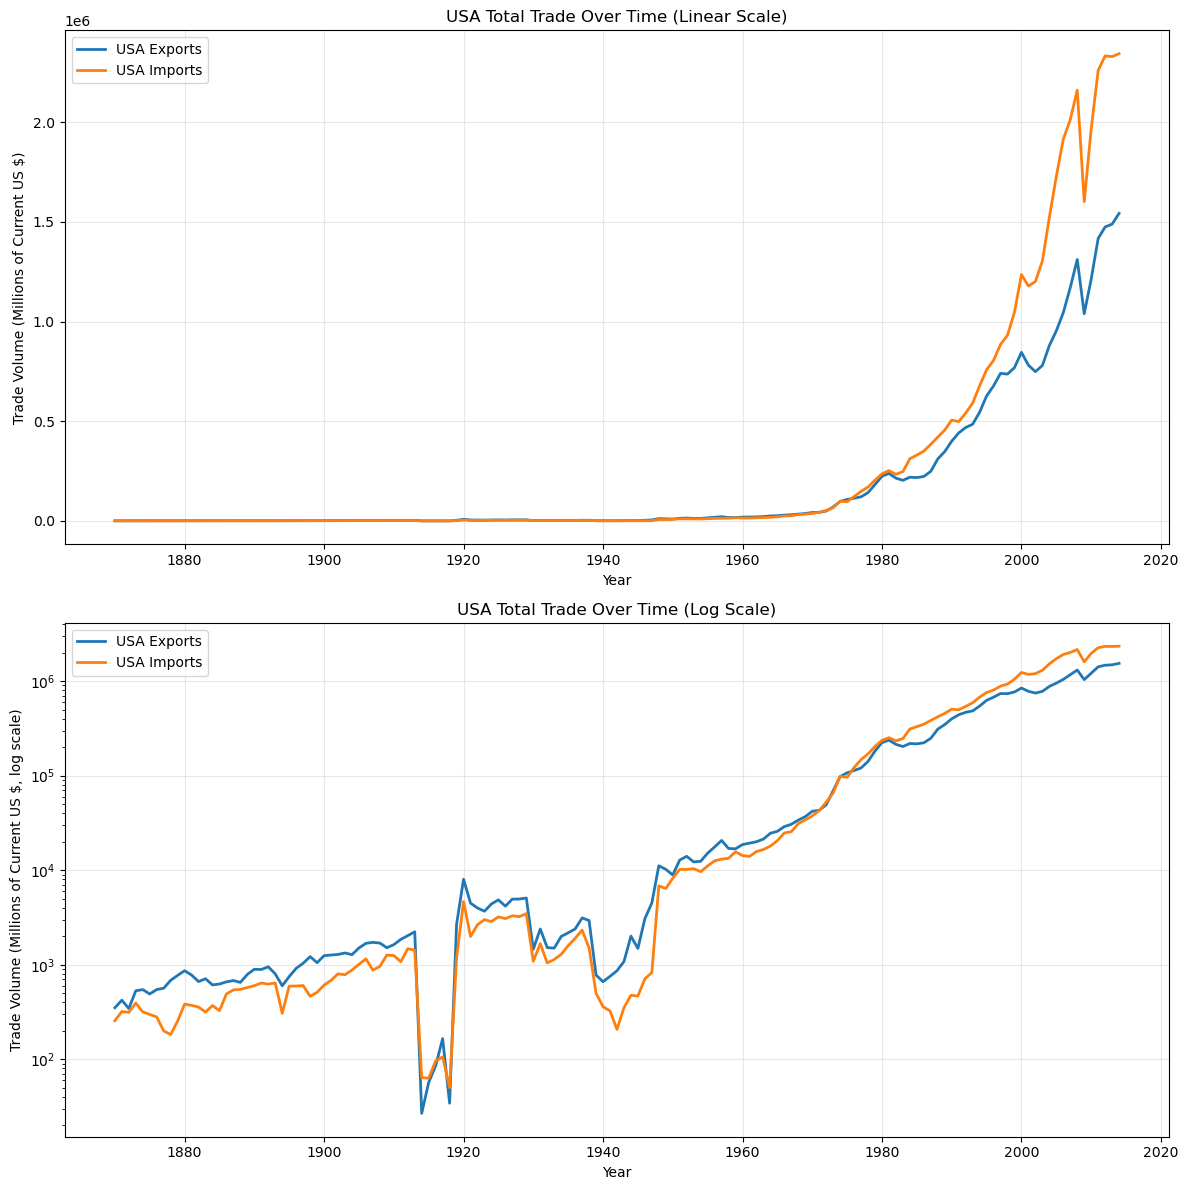


Trade Statistics (in millions of current US $):
Latest year: 2014
Latest exports: 1,542,920.83
Latest imports: 2,344,004.52
Trade balance: -801,083.69


In [25]:
def plot_usa_trade():
    # USA's imports: sum of flow1 when USA is ccode1 and flow2 when USA is ccode2
    usa_imports_as_ccode1 = df[df['ccode1'] == 2].groupby('year')['flow1'].sum()
    usa_imports_as_ccode2 = df[df['ccode2'] == 2].groupby('year')['flow2'].sum()
    usa_total_imports = usa_imports_as_ccode1.add(usa_imports_as_ccode2, fill_value=0)

    # USA's exports: sum of flow2 when USA is ccode1 and flow1 when USA is ccode2
    usa_exports_as_ccode1 = df[df['ccode1'] == 2].groupby('year')['flow2'].sum()
    usa_exports_as_ccode2 = df[df['ccode2'] == 2].groupby('year')['flow1'].sum()
    usa_total_exports = usa_exports_as_ccode1.add(usa_exports_as_ccode2, fill_value=0)

    # Create figure with two subplots: linear and log scale
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Linear scale plot
    ax1.plot(usa_total_exports.index, usa_total_exports.values, label='USA Exports', linewidth=2)
    ax1.plot(usa_total_imports.index, usa_total_imports.values, label='USA Imports', linewidth=2)
    ax1.set_title('USA Total Trade Over Time (Linear Scale)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Trade Volume (Millions of Current US $)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Log scale plot
    ax2.plot(usa_total_exports.index, usa_total_exports.values, label='USA Exports', linewidth=2)
    ax2.plot(usa_total_imports.index, usa_total_imports.values, label='USA Imports', linewidth=2)
    ax2.set_yscale('log')
    ax2.set_title('USA Total Trade Over Time (Log Scale)')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Trade Volume (Millions of Current US $, log scale)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nTrade Statistics (in millions of current US $):")
    print(f"Latest year: {usa_total_exports.index[-1]}")
    print(f"Latest exports: {usa_total_exports.values[-1]:,.2f}")
    print(f"Latest imports: {usa_total_imports.values[-1]:,.2f}")
    print(f"Trade balance: {(usa_total_exports.values[-1] - usa_total_imports.values[-1]):,.2f}")

plot_usa_trade()

Here I quickly spotted that using log-transformed y-axis' would benefit me greatly, if I wanted to better understand behaveiors in the earlier years, since the exponential nature in the normal domain, made it difficult to really discern anything. However in the log-domain of the y-axis, it becomes very clear that thge trend is basically perfect exponential, expressed by a nice linear curve in log-domain. 

Another key takeaway is the 2 very apparent dips in both imports and exports, that clearly show diminshed trade during the 1. and 2. world wars. This makes a lot of sense, since countries had other priorities, but it could also be an indicator that the records perhaps were incomplete during those times.

The last takeaway for the US alone, is that after 1980 the US slowly began importing more than they exported, whereas they had genereally been a larget export makert up until then.
(This was a very nice trend to observe, since it plays into my motivation)

Building on this, I tried to compare multiple countries using the same kind of setup, but to reduce the amount of contries I sorted them by the largest export markets in 2014, since I am mostly intrested in how the past resulted in the present:

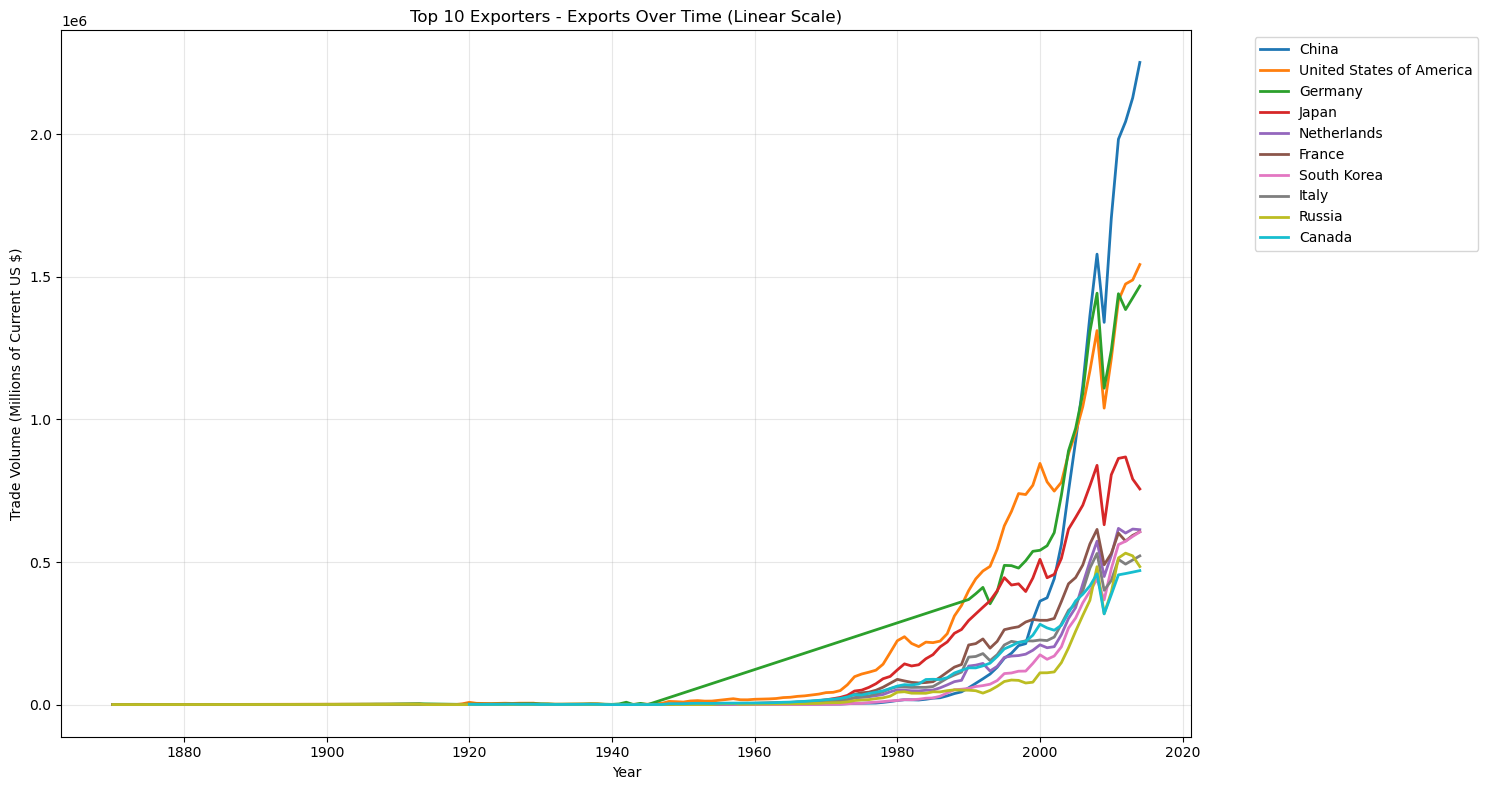

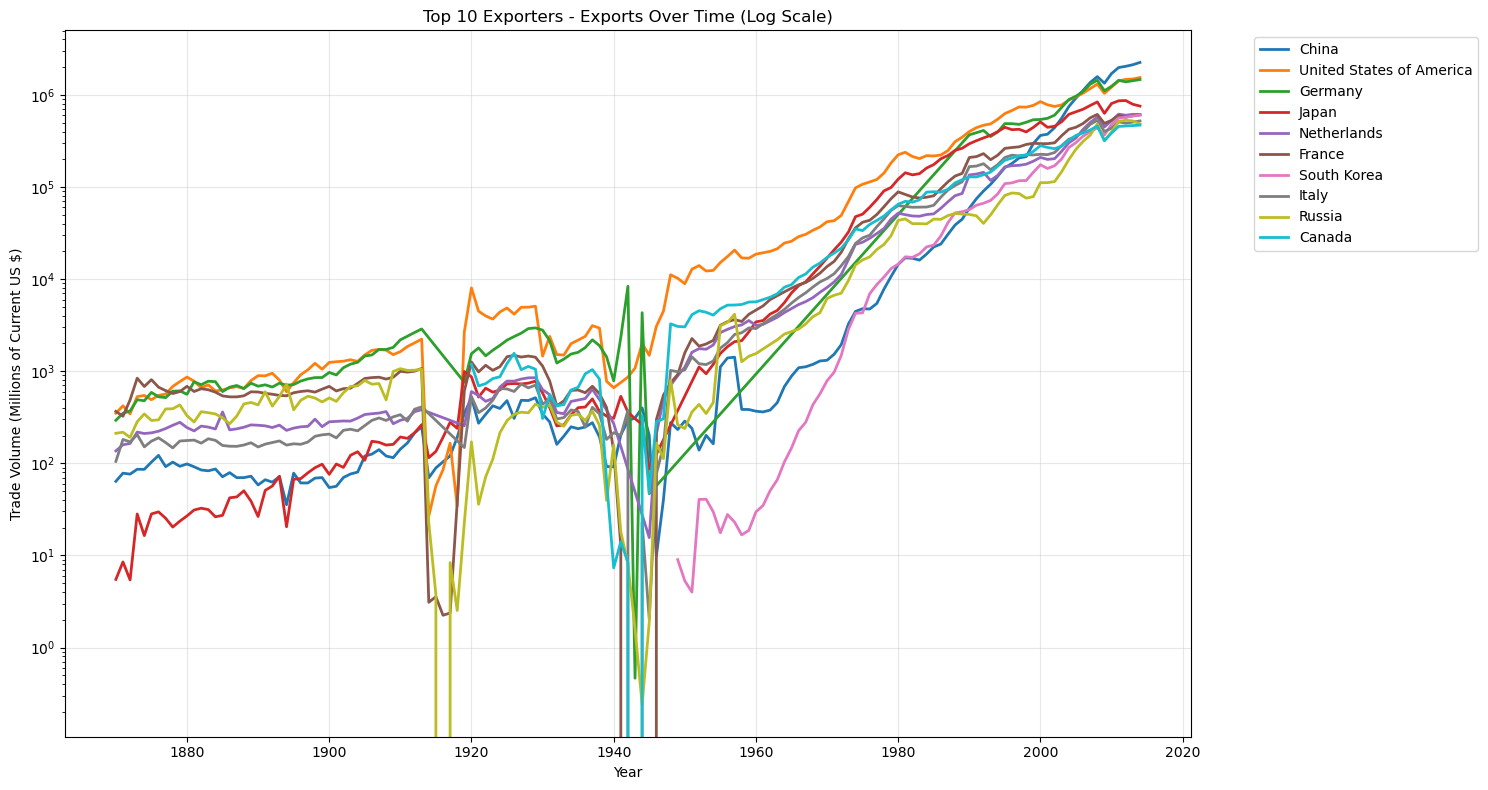

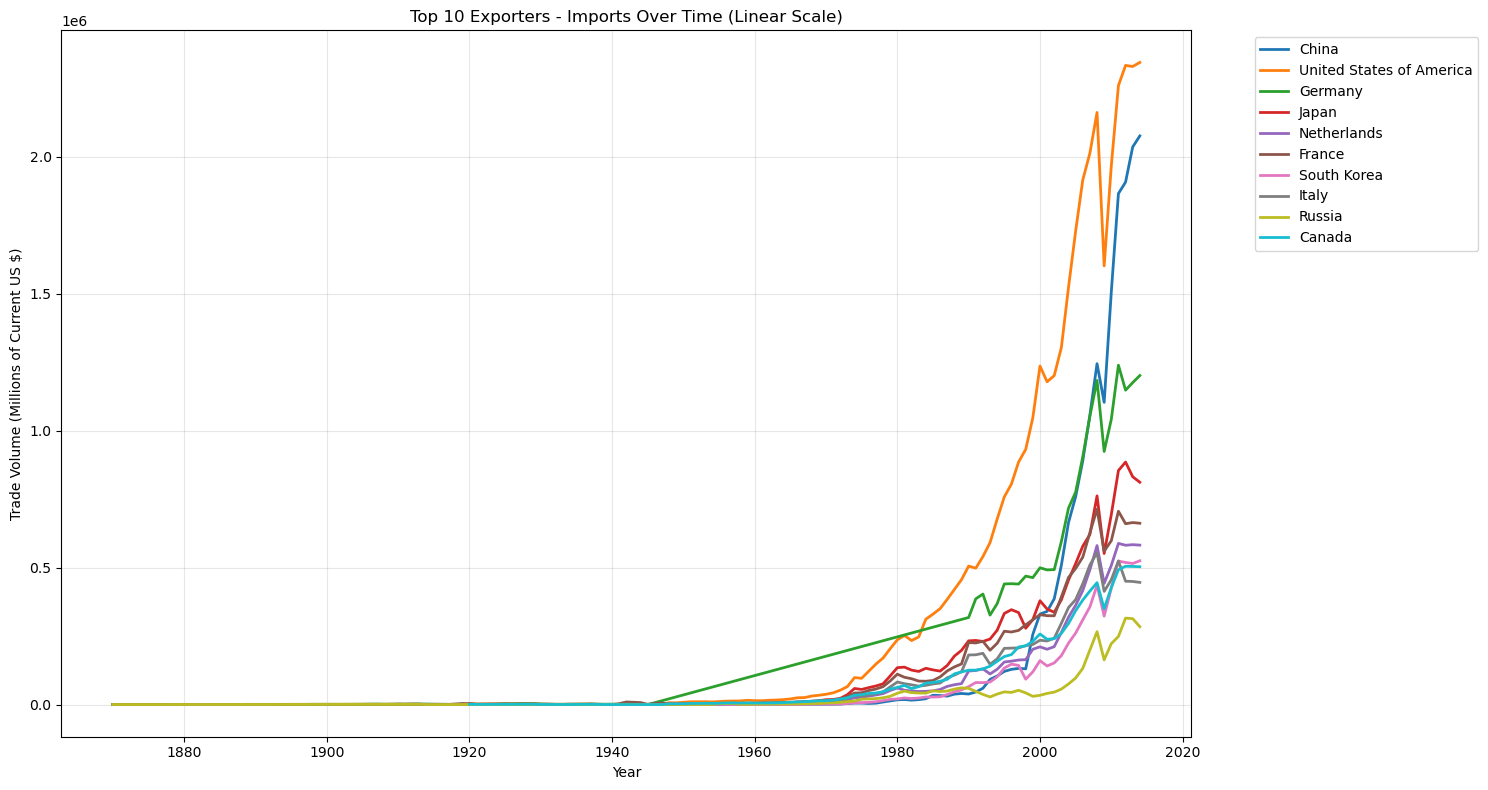

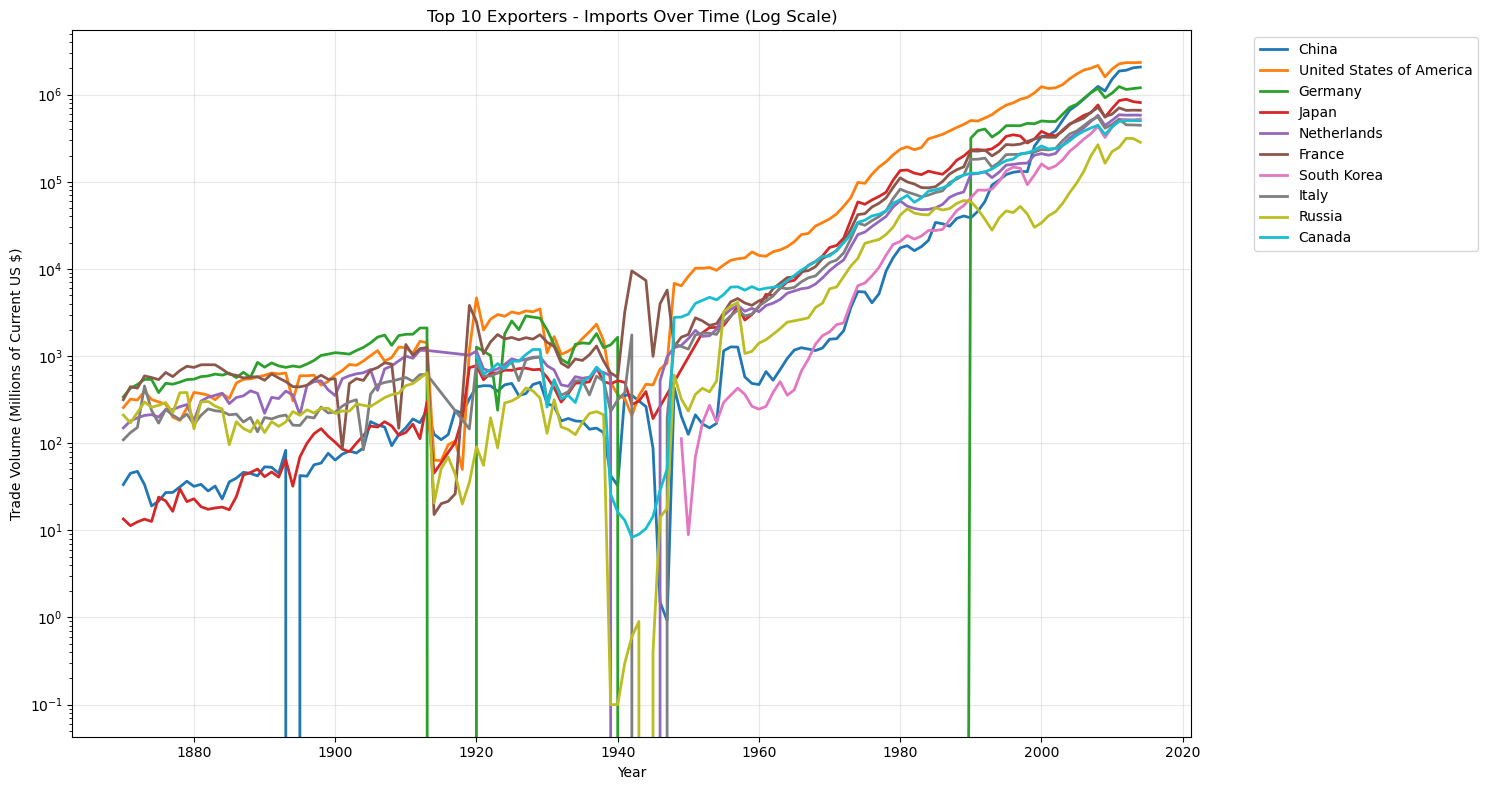


Top 10 Exporters Statistics (in millions of current US $):

China:
Exports: 2,251,540.55
Imports: 2,075,854.44
Trade balance: 175,686.11

United States of America:
Exports: 1,542,920.83
Imports: 2,344,004.52
Trade balance: -801,083.69

Germany:
Exports: 1,467,678.47
Imports: 1,201,134.86
Trade balance: 266,543.61

Japan:
Exports: 756,108.60
Imports: 811,605.97
Trade balance: -55,497.37

Netherlands:
Exports: 613,214.73
Imports: 582,049.83
Trade balance: 31,164.90

France:
Exports: 606,067.54
Imports: 661,923.41
Trade balance: -55,855.86

South Korea:
Exports: 605,367.98
Imports: 524,847.17
Trade balance: 80,520.81

Italy:
Exports: 521,434.24
Imports: 446,032.43
Trade balance: 75,401.81

Russia:
Exports: 483,949.82
Imports: 284,392.19
Trade balance: 199,557.63

Canada:
Exports: 469,807.34
Imports: 503,314.35
Trade balance: -33,507.01


In [26]:
def plot_top_exporters():
    # Get the latest year in the dataset
    latest_year = df["year"].max()

    # Calculate total exports for each country in the latest year
    # For each country, sum both their exports as ccode1 (flow2) and as ccode2 (flow1)
    latest_exports_as_ccode1 = df[df["year"] == latest_year].groupby("ccode1")["flow2"].sum()
    latest_exports_as_ccode2 = df[df["year"] == latest_year].groupby("ccode2")["flow1"].sum()
    latest_total_exports = latest_exports_as_ccode1.add(latest_exports_as_ccode2, fill_value=0)
    
    # Get country names for the codes
    country_names = {}
    for code in latest_total_exports.index:
        # Get name from either importer1 or importer2 where the code matches
        name = df[df["ccode1"] == code]["importer1"].iloc[0] if len(df[df["ccode1"] == code]) > 0 else df[df["ccode2"] == code]["importer2"].iloc[0]
        country_names[code] = name

    # Get top 10 exporters by code
    top_10_exporter_codes = latest_total_exports.nlargest(10).index

    # Create four separate figures
    plt.figure(figsize=(15,8))
    # Plot exports linear scale
    for code in top_10_exporter_codes:
        exports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow2"].sum()
        exports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow1"].sum()
        total_exports = exports_as_ccode1.add(exports_as_ccode2, fill_value=0)
        plt.plot(total_exports.index, total_exports.values, label=country_names[code], linewidth=2)
    
    plt.title("Top 10 Exporters - Exports Over Time (Linear Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15,8))
    # Plot exports log scale
    for code in top_10_exporter_codes:
        exports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow2"].sum()
        exports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow1"].sum()
        total_exports = exports_as_ccode1.add(exports_as_ccode2, fill_value=0)
        plt.plot(total_exports.index, total_exports.values, label=country_names[code], linewidth=2)
    
    plt.yscale('log')
    plt.title("Top 10 Exporters - Exports Over Time (Log Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15,8))
    # Plot imports linear scale
    for code in top_10_exporter_codes:
        imports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow1"].sum()
        imports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow2"].sum()
        total_imports = imports_as_ccode1.add(imports_as_ccode2, fill_value=0)
        plt.plot(total_imports.index, total_imports.values, label=country_names[code], linewidth=2)
    
    plt.title("Top 10 Exporters - Imports Over Time (Linear Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15,8))
    # Plot imports log scale
    for code in top_10_exporter_codes:
        imports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow1"].sum()
        imports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow2"].sum()
        total_imports = imports_as_ccode1.add(imports_as_ccode2, fill_value=0)
        plt.plot(total_imports.index, total_imports.values, label=country_names[code], linewidth=2)
    
    plt.yscale('log')
    plt.title("Top 10 Exporters - Imports Over Time (Log Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print statistics for top exporters
    print("\nTop 10 Exporters Statistics (in millions of current US $):")
    for code in top_10_exporter_codes:
        name = country_names[code]
        exports = latest_total_exports[code]
        imports_as_ccode1 = df[df["year"] == latest_year][df["ccode1"] == code]["flow1"].sum()
        imports_as_ccode2 = df[df["year"] == latest_year][df["ccode2"] == code]["flow2"].sum()
        total_imports = imports_as_ccode1 + imports_as_ccode2
        print(f"\n{name}:")
        print(f"Exports: {exports:,.2f}")
        print(f"Imports: {total_imports:,.2f}")
        print(f"Trade balance: {exports - total_imports:,.2f}")
plot_top_exporters()

While this output is a bit more messy, the main takeaway is that the global market overall developed together, but the US was the top importer globally since the 2. WW and China overtook the export-market greatly somewhere around 2010, showing increadible development compare to other nations. Further not only did the export market develop greatly for China, but so did its import market. Thus genereally showing a emphasiz on the development of the chinese economy.

This opened up the question if the chinese economy had beaten the american, since export is a large factor for growing a countries economy:

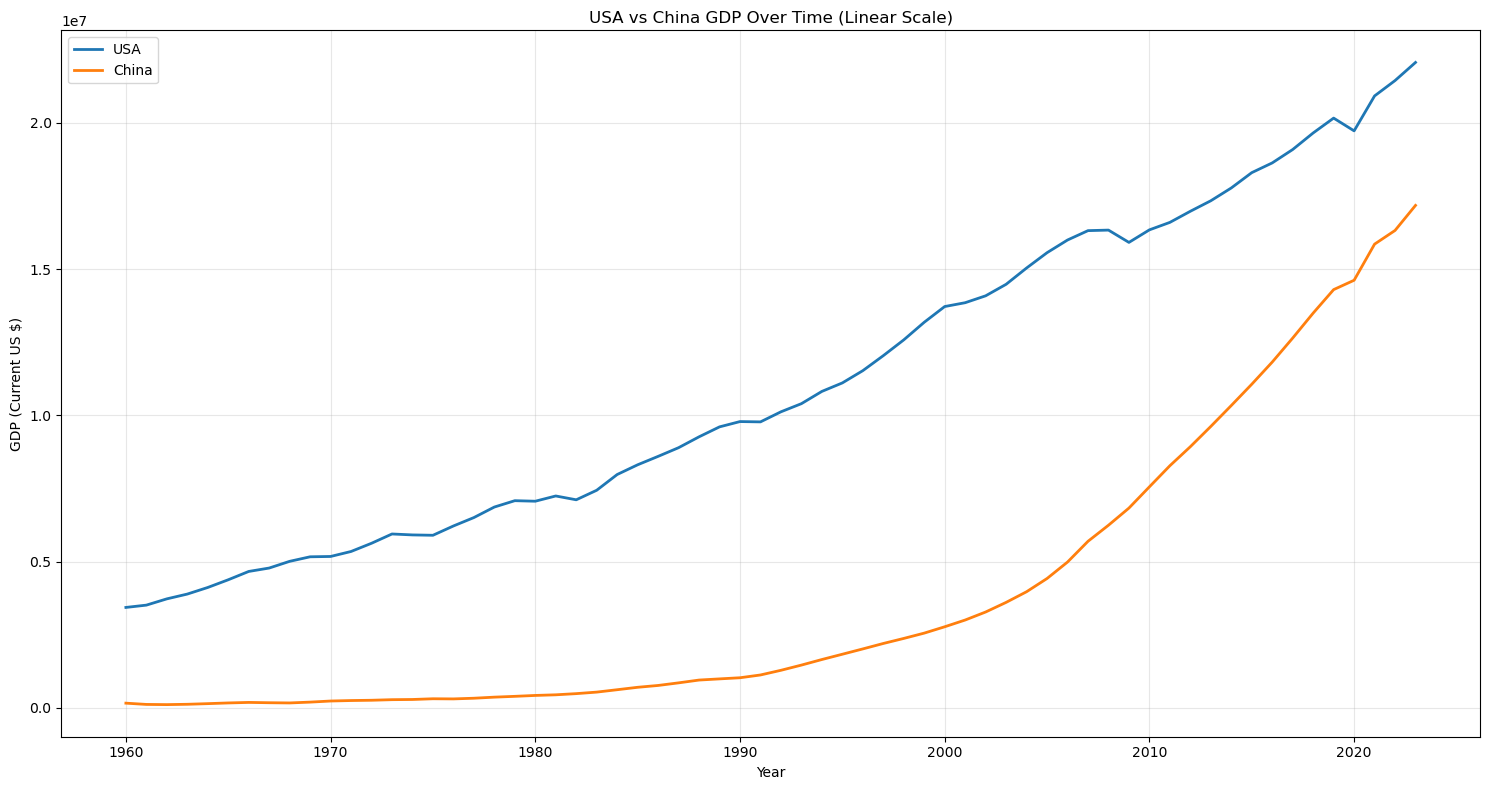

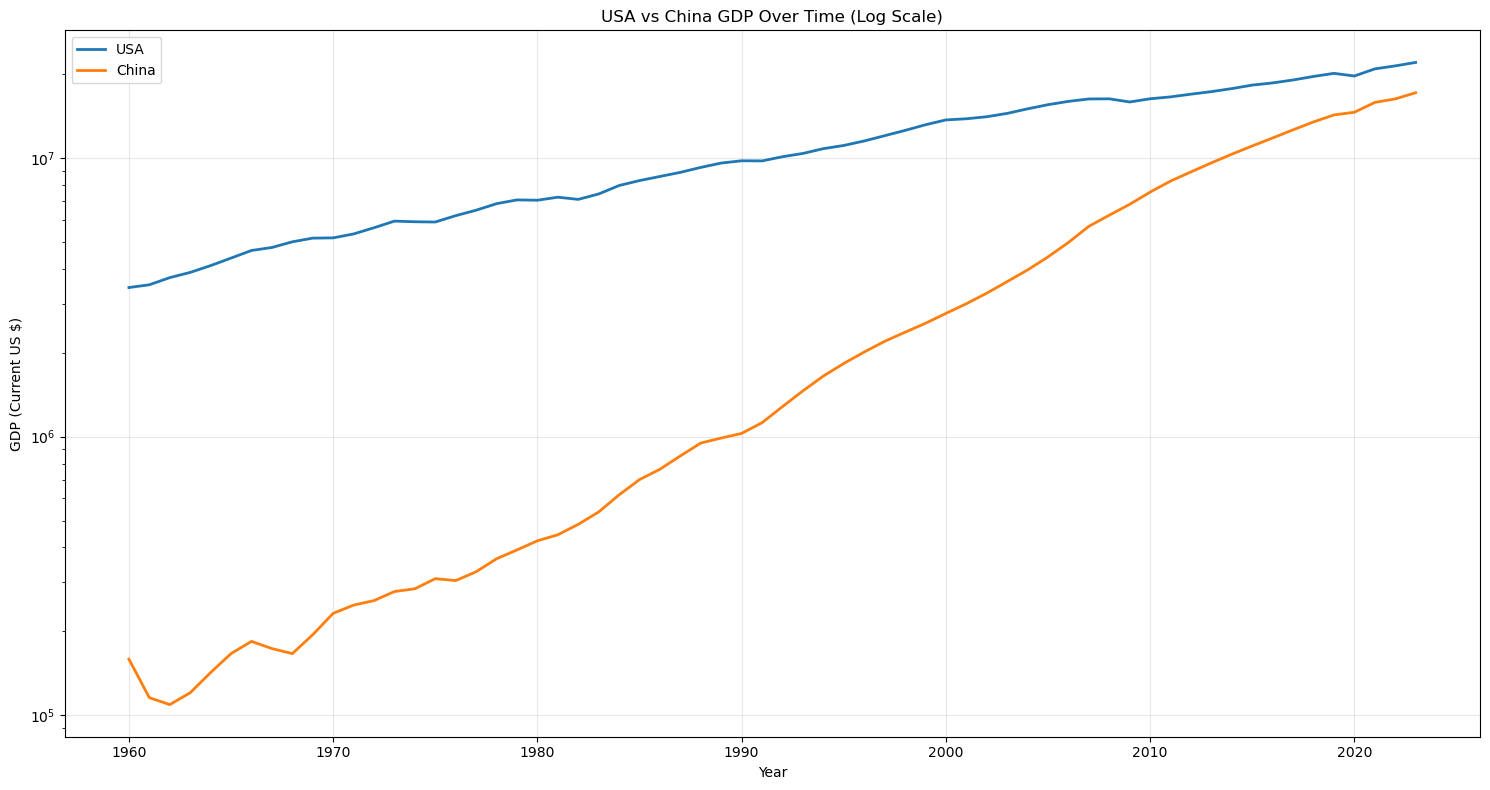

In [27]:
# Get GDP data for USA and China
usa_gdp = load_and_process_gdp(["USA"])
china_gdp = load_and_process_gdp(["chn"])

# Create linear scale plot
plt.figure(figsize=(15,8))
plt.plot(usa_gdp.index, usa_gdp.values, label='USA', linewidth=2)
plt.plot(china_gdp.index, china_gdp.values, label='China', linewidth=2)
plt.title("USA vs China GDP Over Time (Linear Scale)")
plt.xlabel("Year") 
plt.ylabel("GDP (Current US $)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Create log scale plot
plt.figure(figsize=(15,8))
plt.plot(usa_gdp.index, usa_gdp.values, label='USA', linewidth=2)
plt.plot(china_gdp.index, china_gdp.values, label='China', linewidth=2)
plt.yscale('log')
plt.title("USA vs China GDP Over Time (Log Scale)")
plt.xlabel("Year")
plt.ylabel("GDP (Current US $)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

At this point it became apparent to me that it really do not understand how GDPs actually work, as I assume there were more of a direct relationship between the import/export ratio, and the GDP of a country. However I learned that it is also effected by a multitude of national measurements:
https://www.britannica.com/money/gross-domestic-product

Nevertheless, the GDP data is quite recent but it can be difficult to really extrapolate how the world will develop given the current geopolitical situation, but going just from data, it would seem China are on a much steeper development, and will soon overtake US in economic strength. 

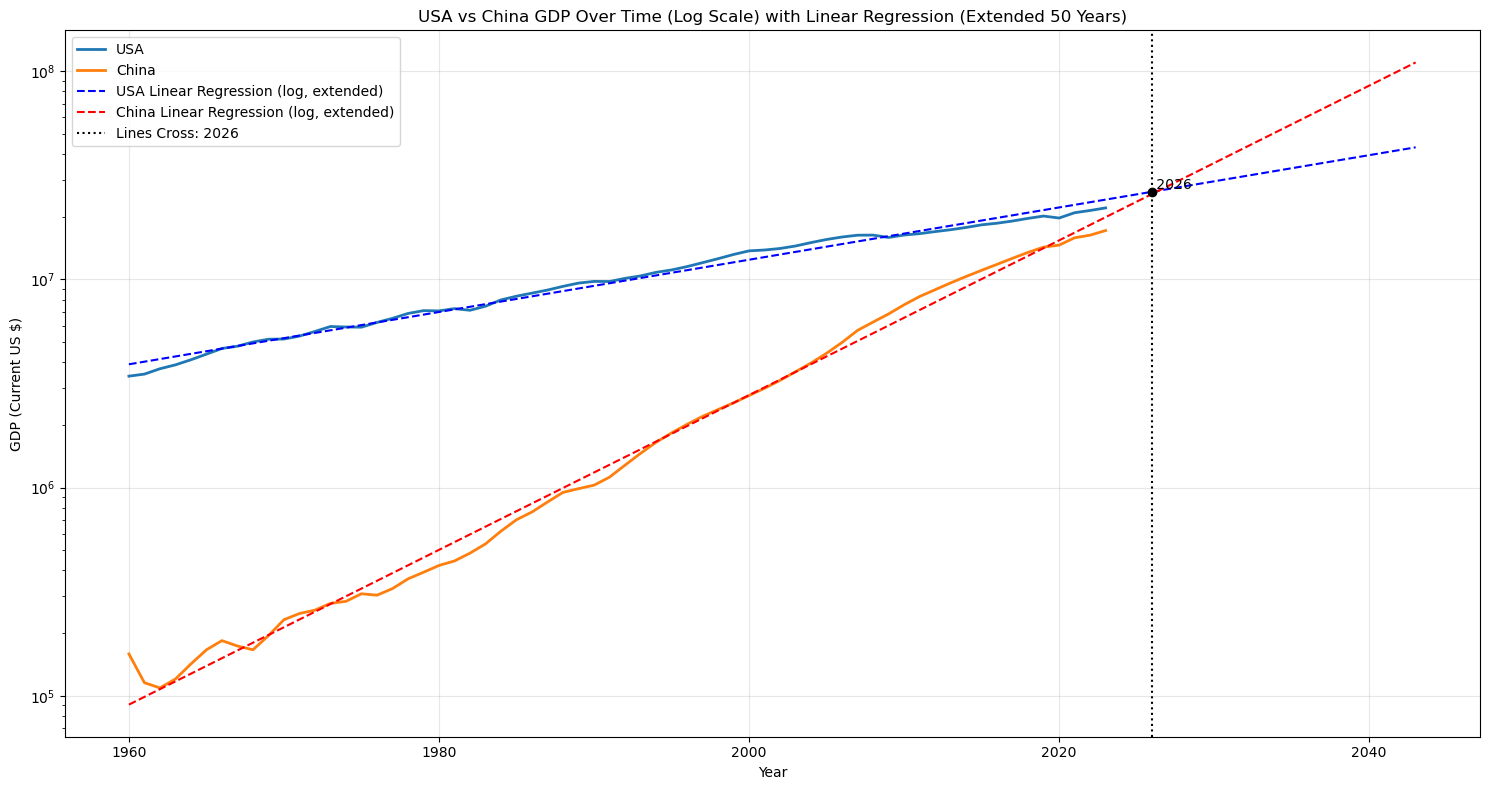

In [39]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Prepare data
years = usa_gdp.index.values.reshape(-1, 1)
log_usa = np.log(usa_gdp.values)
log_china = np.log(china_gdp.values)

# Fit linear regression (on log values)
reg_usa = LinearRegression().fit(years, log_usa)
reg_china = LinearRegression().fit(years, log_china)

# Extend years 20 years into the future
future_years = np.arange(years.min(), years.max() + 21).reshape(-1, 1)

# Predict regression lines for extended years
log_usa_pred = reg_usa.predict(future_years)
log_china_pred = reg_china.predict(future_years)

# Find intersection year (where regression lines cross)
a1, b1 = reg_usa.coef_[0], reg_usa.intercept_
a2, b2 = reg_china.coef_[0], reg_china.intercept_
if a1 != a2:
    cross_year = (b2 - b1) / (a1 - a2)
    cross_year = int(np.round(cross_year))
    cross_gdp = np.exp(reg_usa.predict([[cross_year]]))[0]
else:
    cross_year = None

plt.figure(figsize=(15,8))
plt.plot(usa_gdp.index, usa_gdp.values, label='USA', linewidth=2)
plt.plot(china_gdp.index, china_gdp.values, label='China', linewidth=2)
plt.yscale('log')

# Plot regression lines (dashed) for extended years
plt.plot(future_years.flatten(), np.exp(log_usa_pred), 'b--', label='USA Linear Regression (log, extended)')
plt.plot(future_years.flatten(), np.exp(log_china_pred), 'r--', label='China Linear Regression (log, extended)')

# Mark intersection
if cross_year is not None and future_years.min() <= cross_year <= future_years.max():
    plt.axvline(x=cross_year, color='k', linestyle=':', label=f'Lines Cross: {cross_year}')
    plt.scatter([cross_year], [cross_gdp], color='k', zorder=5)
    plt.text(cross_year, cross_gdp, f' {cross_year}', va='bottom', ha='left')

plt.title("USA vs China GDP Over Time (Log Scale) with Linear Regression (Extended 50 Years)")
plt.xlabel("Year")
plt.ylabel("GDP (Current US $)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Trying to simply estimate it using linear regression is perhaps a bit naive, given that it is actually visually represented that the linear regression overestimated the development of both countries growth, at the end of the dataset. In constrast it could perhaps mean that the rapid development of both countries economies are slowing down.

Then looking back into if we can even expect to trust the current developments, given the current geopolitical situation, with still (as of start May 2025) heavy Tariffs between the US and China, we can see in the below plot that they are each others biggest trades partners:

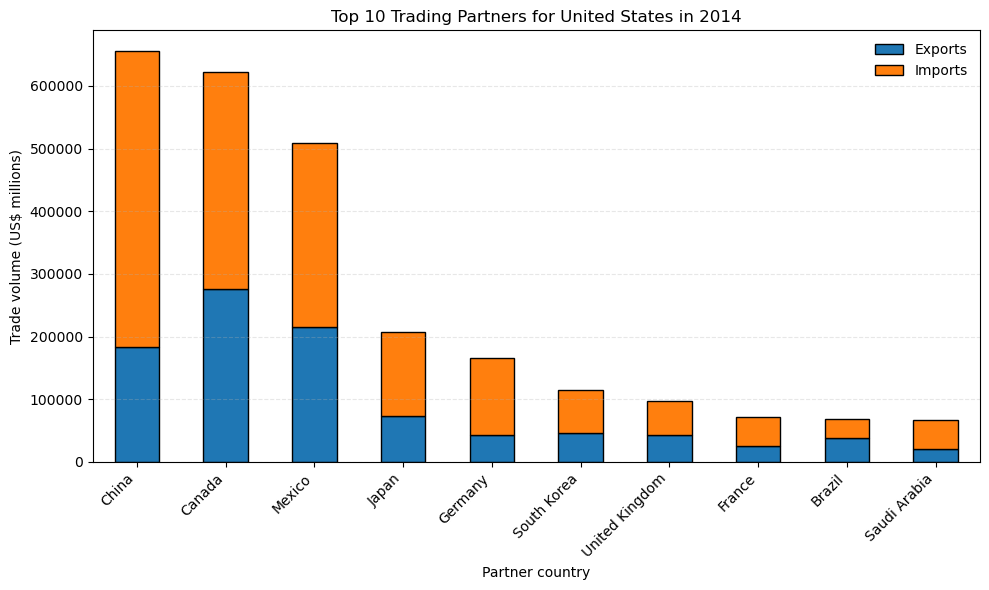

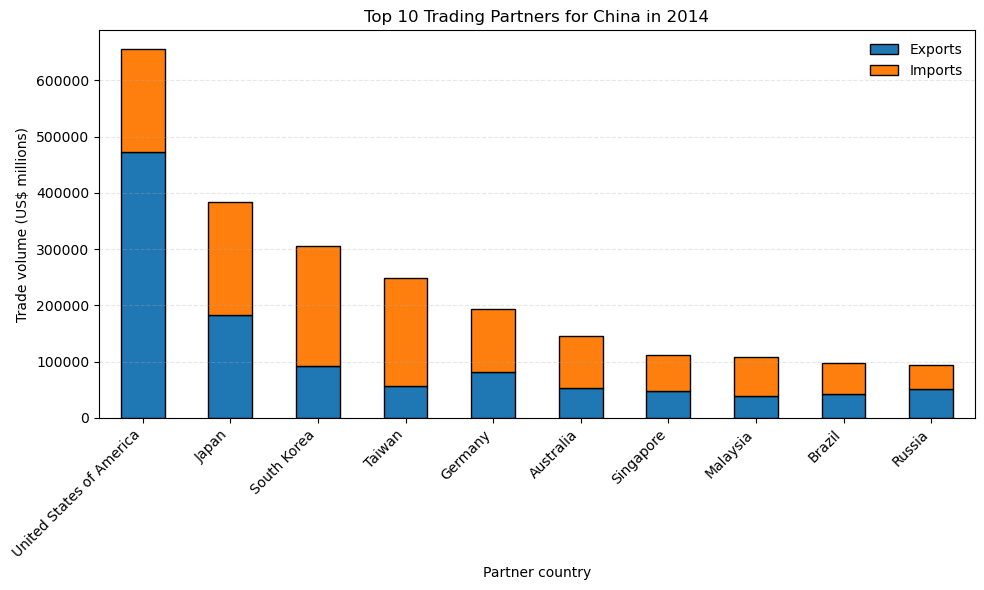

In [45]:
def plot_top_markets_stacked(ccode: int,
                             country_name: str,
                             year: int = 2014,
                             n_partners: int = 10) -> None:

    df_y = df[df["year"] == year]

    # --- exports & imports ----------------------------------------------------
    exp_a = df_y.loc[df_y["ccode1"] == ccode].set_index("ccode2")["flow2"]
    imp_a = df_y.loc[df_y["ccode1"] == ccode].set_index("ccode2")["flow1"]
    exp_b = df_y.loc[df_y["ccode2"] == ccode].set_index("ccode1")["flow1"]
    imp_b = df_y.loc[df_y["ccode2"] == ccode].set_index("ccode1")["flow2"]

    exports = pd.concat([exp_a, exp_b]).groupby(level=0).sum().rename("Exports")
    imports = pd.concat([imp_a, imp_b]).groupby(level=0).sum().rename("Imports")

    trade = pd.concat([exports, imports], axis=1).fillna(0)
    trade["Total"] = trade["Exports"] + trade["Imports"]
    top = trade.nlargest(n_partners, "Total").sort_values("Total", ascending=False)

    # --- partner names --------------------------------------------------------
    names = pd.concat([
        df_y[["ccode1", "importer1"]].rename(columns={"ccode1": "ccode",
                                                      "importer1": "name"}),
        df_y[["ccode2", "importer2"]].rename(columns={"ccode2": "ccode",
                                                      "importer2": "name"})
    ])
    name_map = names.drop_duplicates("ccode").set_index("ccode")["name"]
    top.index = top.index.map(name_map.get)

    # --- plot -----------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))
    top[["Exports", "Imports"]].plot.bar(stacked=True,
                                         ax=ax,
                                         color=("#1f77b4", "#ff7f0e"),
                                         edgecolor="black")

    ax.set_title(f"Top {n_partners} Trading Partners for {country_name} in {year}")
    ax.set_xlabel("Partner country")
    ax.set_ylabel("Trade volume (US$ millions)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(frameon=False)
    ax.grid(axis="y", linestyle="--", alpha=.3)
    fig.tight_layout()
    plt.show()
plot_top_markets_stacked(2,   "United States")
plot_top_markets_stacked(710, "China")

Since the US and China are each others biggest markets, a trade-war would hurt both economies greatly.

### Network analysis

Now to do something a bit different I also try to visualize the trade networks throughout time

In [47]:
def plot_trade_network(df,year = 1920):
    # Filter data for 1920
    df = df[df["year"] == year]

    # Create directed graph
    G = nx.DiGraph()

    # Add edges with weights
    for _, row in df.iterrows():
        if row["flow1"] > 0:  # Only add significant trade flows
            G.add_edge(
                row["importer1"], row["importer2"], weight=(row["flow1"]+row["flow2"]) / 1000
            )  # Scale down weights for better visualization

    # Calculate node sizes based on total trade volume
    node_sizes = []
    for node in G.nodes():
        total_trade = sum(
            [G[node][neighbor]["weight"] for neighbor in G.neighbors(node)]
        )
        node_sizes.append(total_trade)

    # Normalize node sizes
    node_sizes = np.array(node_sizes)
    node_sizes = (
        1000
        + (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min()) * 9000
    )

    # Create the plot
    plt.figure(figsize=(15, 15))

    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, arrows=True, arrowsize=10)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Global Trade Network - " + str(year))
    plt.axis("off")

    # Save the plot
    # plt.savefig("_visualizations/trade_network_1920.png", dpi=300, bbox_inches="tight")
    # plt.close()
    plt.show()



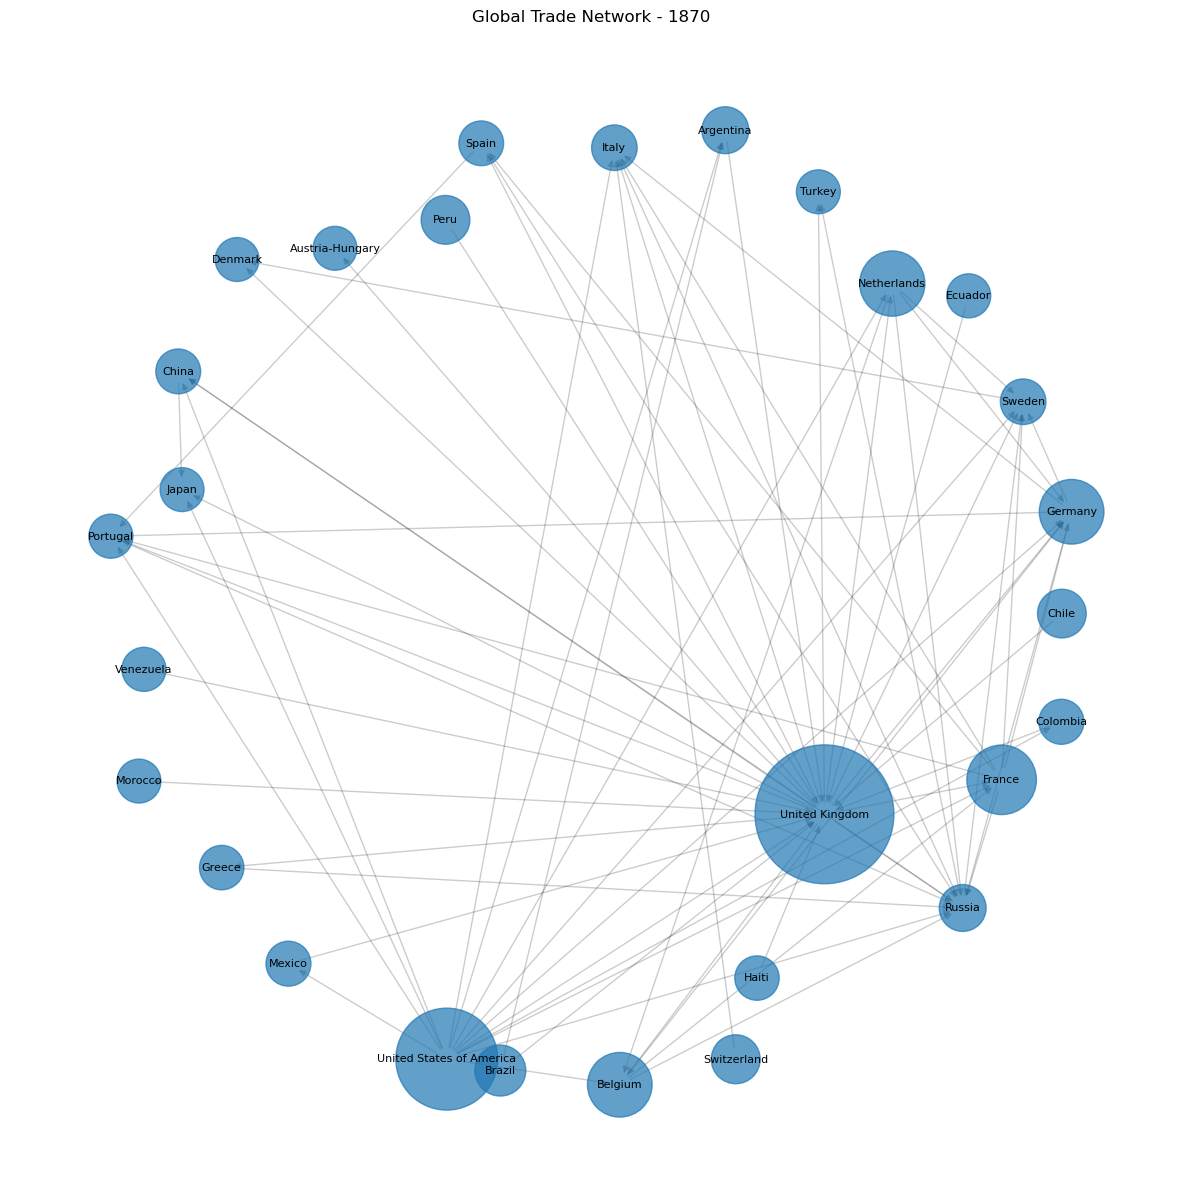

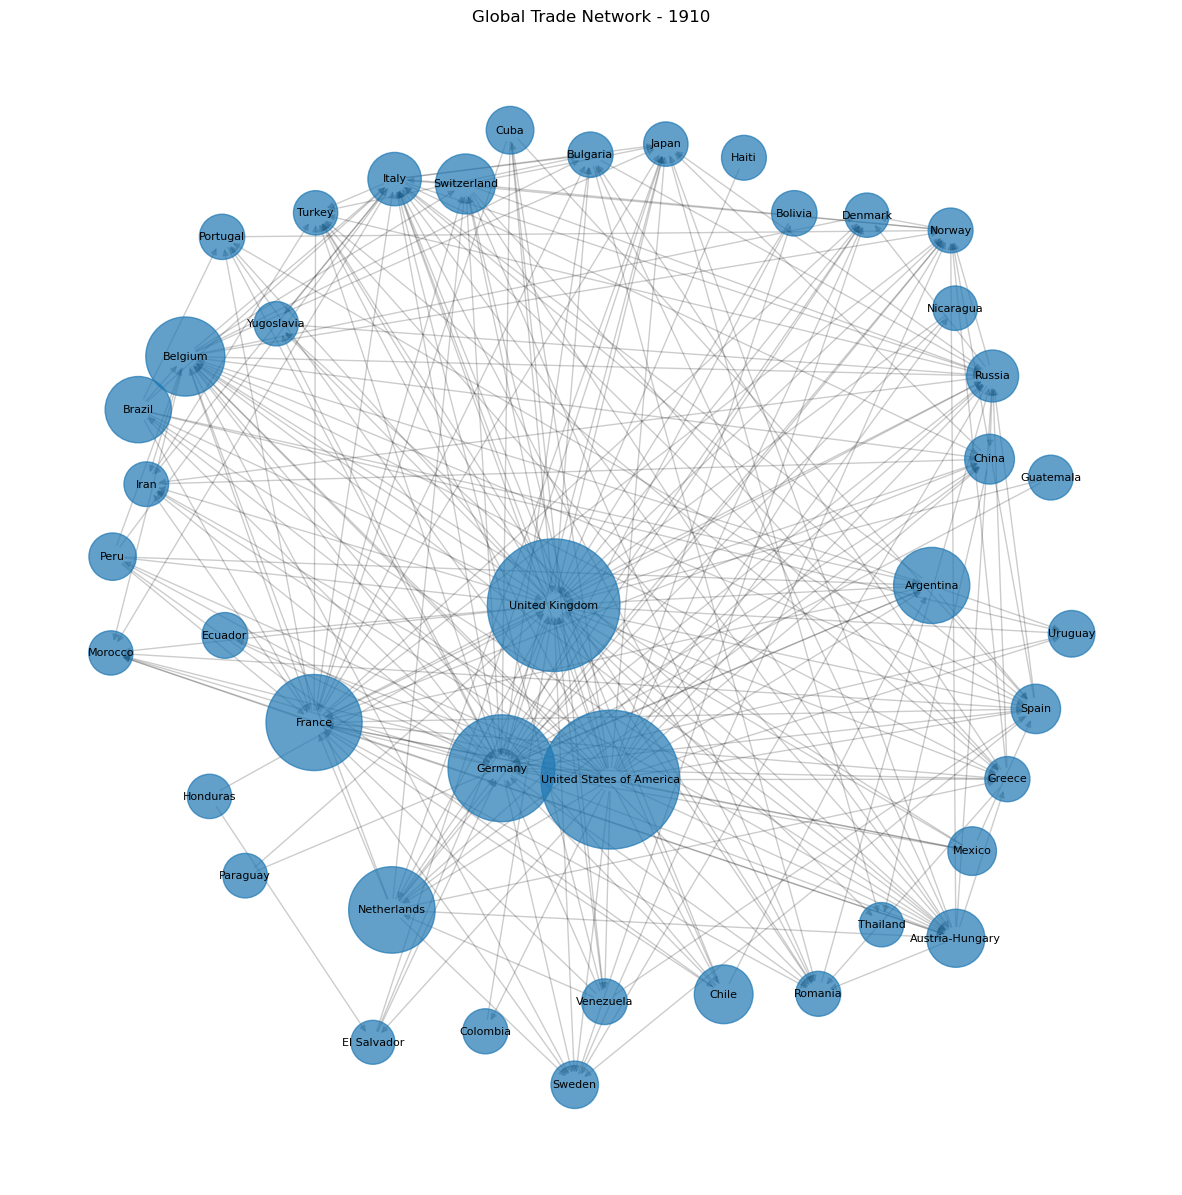

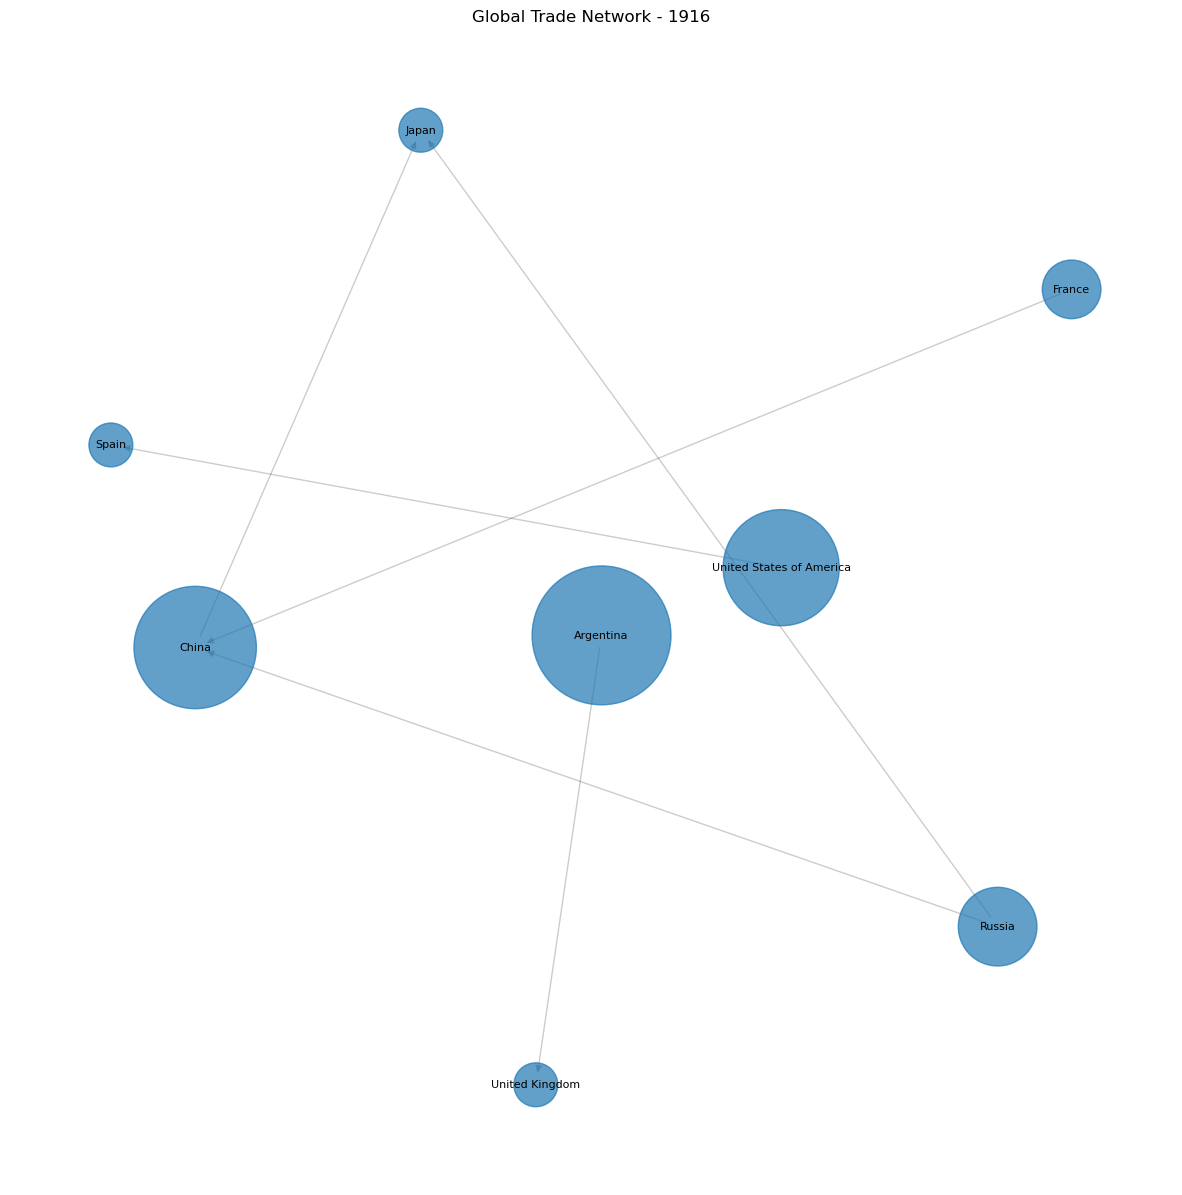

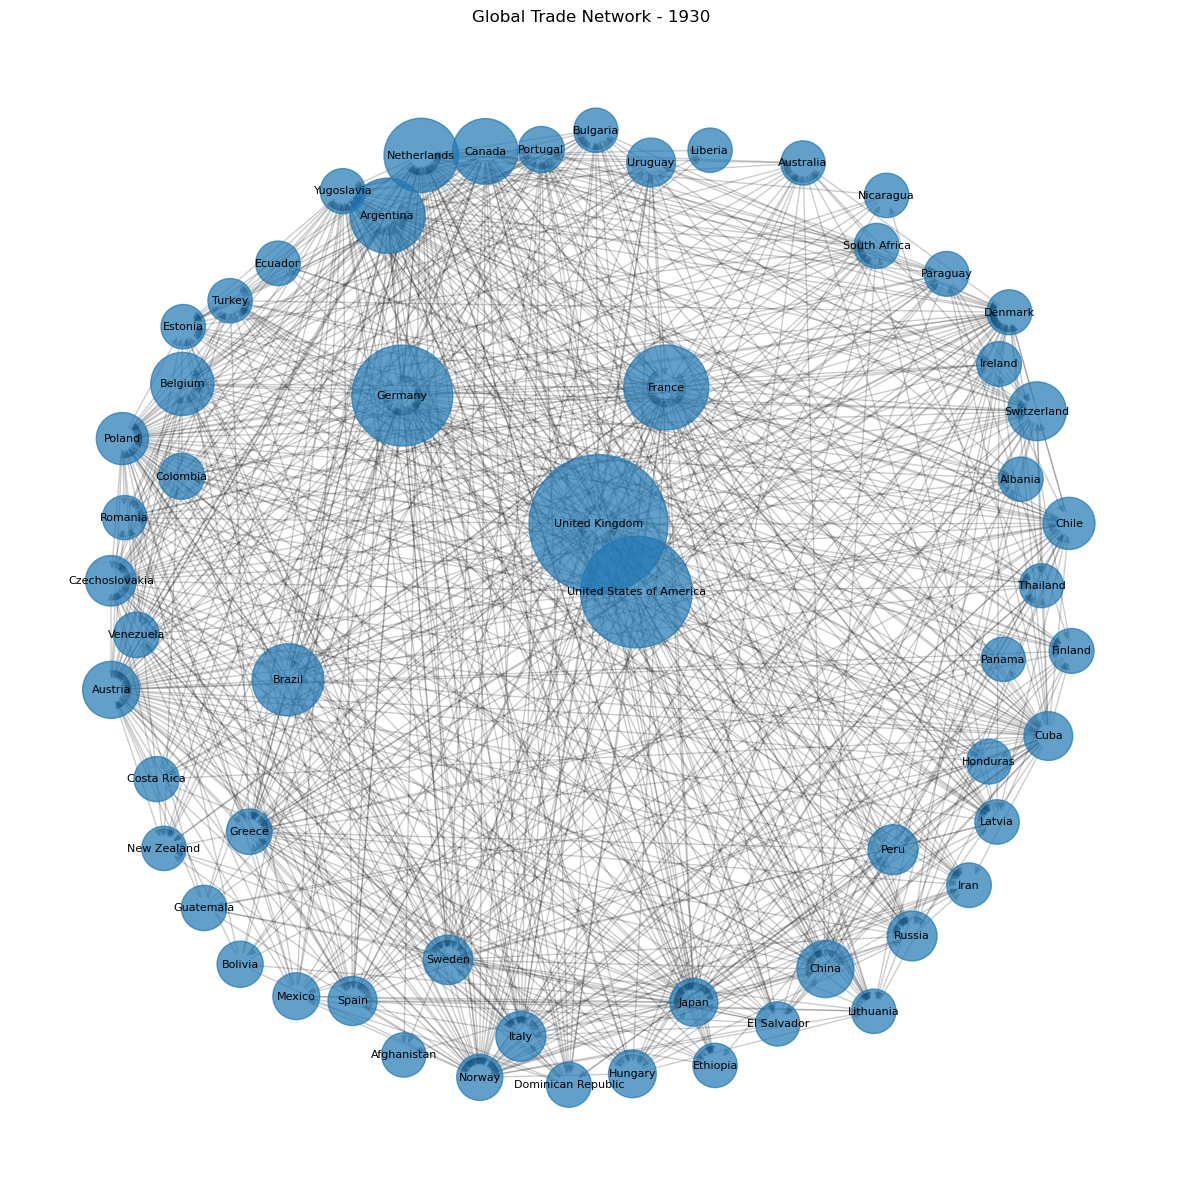

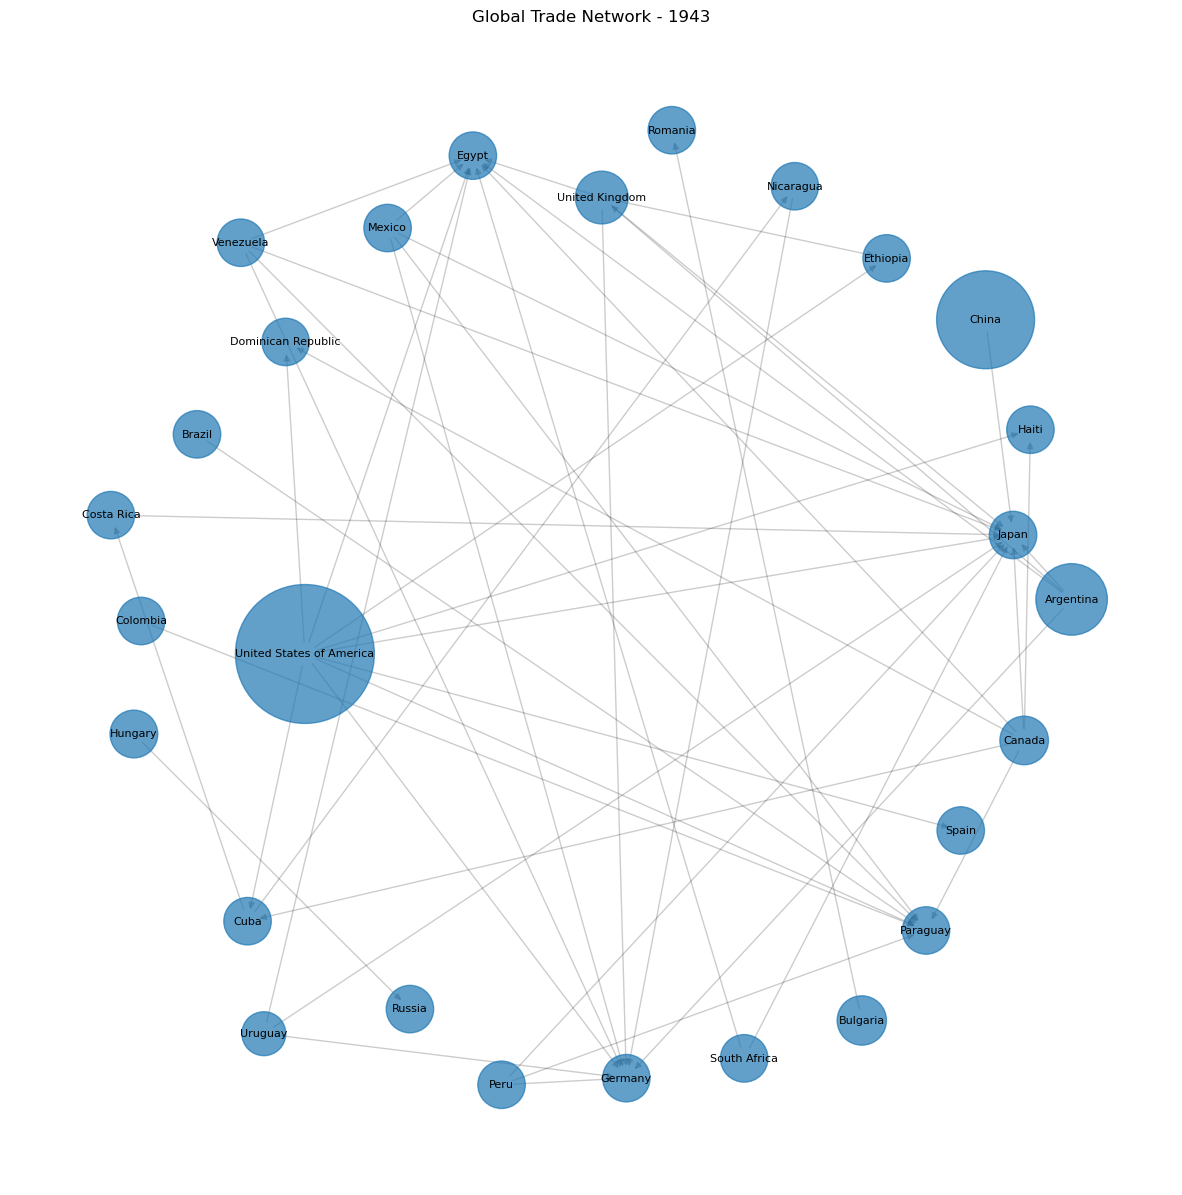

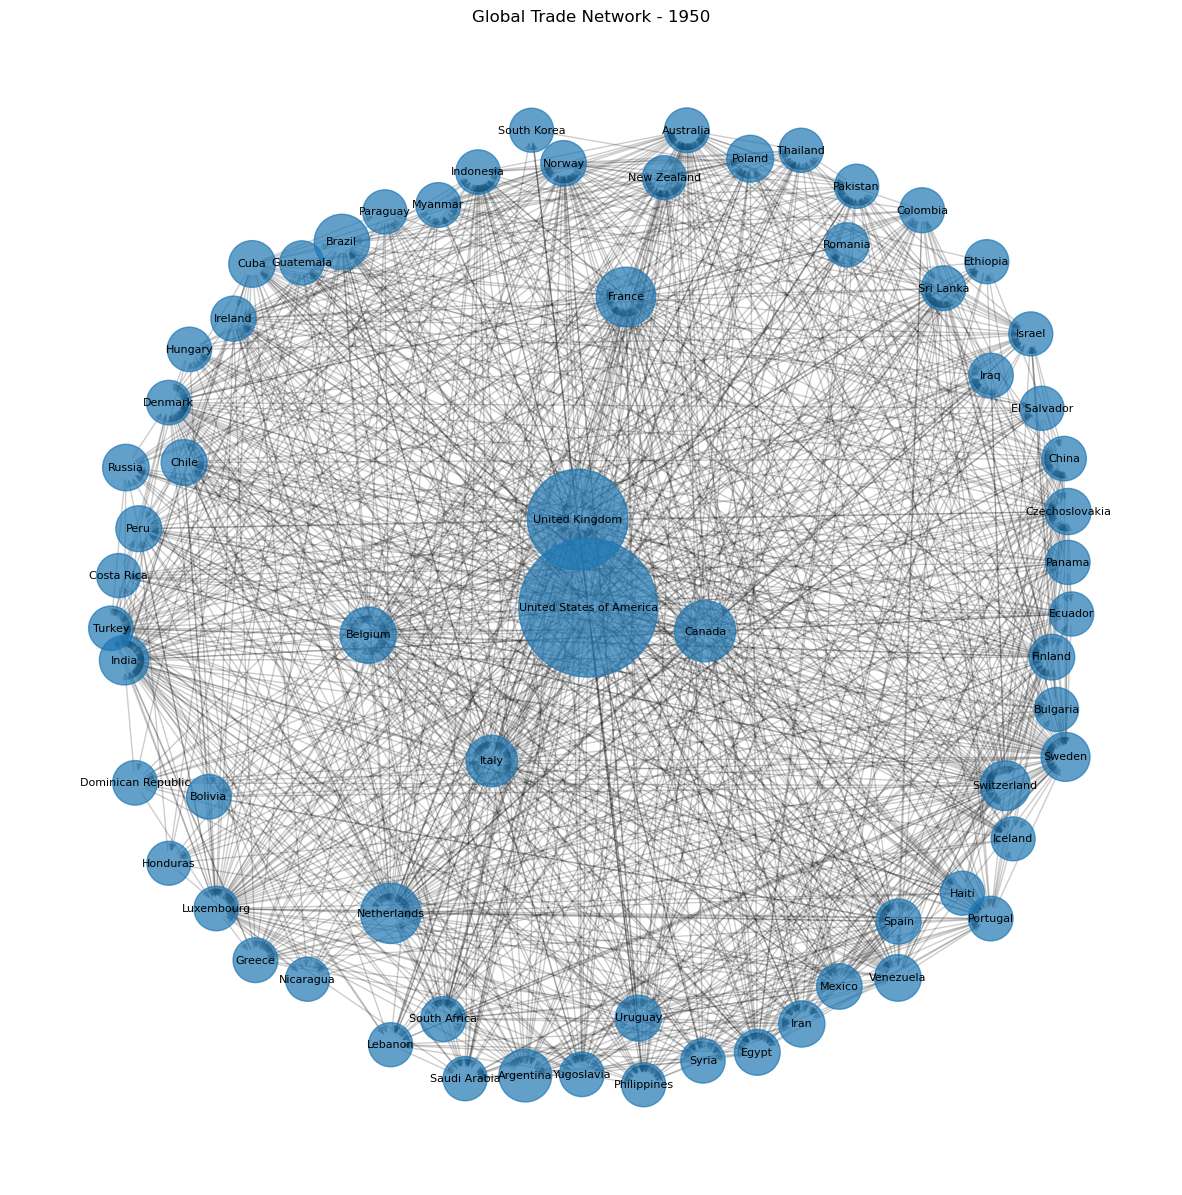

In [50]:
plot_trade_network(df,1870)
plot_trade_network(df,1910)
plot_trade_network(df,1916)

plot_trade_network(df,1930)
plot_trade_network(df,1943)
plot_trade_network(df,1950)
# plot_trade_network(df,1950)
# plot_trade_network(df,1980)
# plot_trade_network(df,2000)
# plot_trade_network(df,2014)

# plot_trade_network(2014)

These plots rapidly become difficult to really interpret, but alone going off the size of the nodes which is a measure of a countries total trade, we can see how UK is the largest trade partner for many years, which I guess is a remnant from them being one of the first actual super powers.

Likewise I have here choosen to show some world war years, to also showcase how sparse the trading communities become during world wars. On the other hand the war years make it very visual that the dataset isnt perfect, since there is seemingly no trade between US and UK during 1943, despite them being close allies during WW2 and UK seemingly still trading with Germany.

To better quantify these effects over time, I dont just want to show how they develop as actual graphs, but rather also show them as timeseries data using measures such as network centralities:

In [51]:
def calculate_centralities(G):
    """Calculate various centralities for a graph"""
    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    
    # Eigenvector centrality
    # try:
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=10000)
    # except:
    #     # If eigenvector centrality fails, use degree centrality as fallback
    #     eigenvector_centrality = degree_centrality
    
    return {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'eigenvector': eigenvector_centrality
    }

def calculate_centralities_for_years(df, years=None):
    """
    Calculate centralities for all years in the dataset
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The trade data dataframe
    years : list, optional
        Specific years to calculate centralities for. If None, uses all years in df
    
    Returns:
    --------
    dict
        Dictionary containing centrality measures for each year
    """
    if years is None:
        years = sorted(df['year'].unique())
    
    # Initialize storage for centralities
    centralities = {
        'degree': {},
        'betweenness': {},
        'eigenvector': {}
    }
    
    # Calculate centralities for each year
    for year in tqdm(years):
        # Create graph for this year
        G = nx.DiGraph()
        
        # Add edges with weights
        year_data = df[df['year'] == year]
        for _, row in year_data.iterrows():
            if row['flow1'] > 0:  # Only add significant trade flows
                G.add_edge(row['importer1'], row['importer2'], 
                          weight=row['flow1'])
        
        # Calculate centralities
        year_centralities = calculate_centralities(G)
        
        # Store results
        for centrality_type in centralities:
            centralities[centrality_type][year] = year_centralities[centrality_type]
    
    return centralities

centralities = calculate_centralities_for_years(df)


100%|██████████| 145/145 [01:01<00:00,  2.36it/s]


In [52]:
def get_top_exporters(n=10):
    """Get the top n exporters based on total trade volume"""
    # Calculate total exports for each country
    total_exports = df.groupby('importer1')['flow1'].sum().sort_values(ascending=False)
    return total_exports.head(n).index.tolist()


In [55]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


def plot_country_centralities(countries=None,
                              n_countries: int = 10,
                              centralities: dict | None = None):
    """
    Interactive time-series of three network–centrality measures.

    Parameters
    ----------
    countries : list[str] or None
        COW country codes to plot.  If None, uses the top *n_countries*
        exporters (get_top_exporters must exist in scope).
    n_countries : int, default 10
        Number of countries selected when *countries* is None.
    centralities : dict[str, dict[int, dict[str, float]]] or None
        Pre-computed centralities in the form
            {'degree':      {year: {ccode: value, …}, …},
             'betweenness': {year: {…}},
             'eigenvector': {year: {…}}}
        If None, they are computed on the fly by
        `calculate_centralities_for_years(df, years)`.
    """

    # 1 ── country set & calendar years ────────────────────────────────────────
    if countries is None:
        countries = get_top_exporters(n_countries)

    years = sorted(df['year'].unique())

    if centralities is None:
        centralities = calculate_centralities_for_years(df, years)

    # 2 ── figure skeleton: 3 rows × 1 column ─────────────────────────────────
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.07,
        subplot_titles=[
            'Degree Centrality',
            'Betweenness Centrality',
            'Eigenvector Centrality'
        ]
    )

    palette = px.colors.qualitative.Set1

    # 3 ── add traces ─────────────────────────────────────────────────────────
    for idx, c_type in enumerate(['degree', 'betweenness', 'eigenvector'], start=1):
        for j, country in enumerate(countries):
            series = [
                centralities[c_type][yr].get(country, 0)
                for yr in years
            ]

            fig.add_trace(
                go.Scatter(
                    x=years,
                    y=series,
                    name=country,
                    line=dict(color=palette[j % len(palette)]),
                    showlegend=(idx == 1),                          # legend only once
                    hovertemplate=(
                        "<b>%{x}</b><br>"
                        f"Country: {country}<br>"
                        f"{c_type.capitalize()} : %{{y:.4f}}<extra></extra>"
                    )
                ),
                row=idx, col=1
            )

    # 4 ── layout tweaks ──────────────────────────────────────────────────────
    fig.update_layout(
        title_text="Network-Centrality Development for Selected Countries",
        height=1_000,
        width=1_000,
        hovermode='x unified',
        legend=dict(
            yanchor="top", y=0.99,
            xanchor="left", x=1.02
        ),
        margin=dict(l=60, r=200, t=80, b=40)
    )

    for r in range(1, 4):
        fig.update_yaxes(title_text="Centrality value", row=r, col=1)
    fig.update_xaxes(title_text="Year", row=3, col=1)

    fig.show()

    # 5 ── console snapshot of the latest year ────────────────────────────────
    latest_year = years[-1]
    print(f"\nCentrality values for {latest_year}:")
    for c_type in ['degree', 'betweenness', 'eigenvector']:
        print(f"\n{c_type.capitalize()} centrality")
        for country in countries:
            v = centralities[c_type][latest_year].get(country, 0)
            print(f"  {country}: {v:.4f}")
# centralities = calculate_centralities_for_years(df)
top_countries = get_top_exporters(3)
plot_country_centralities(countries=top_countries, centralities=centralities)

100%|██████████| 145/145 [01:01<00:00,  2.37it/s]



Centrality values for 2014:

Degree centrality
  United States of America: 0.9784
  United Kingdom: 0.9892
  China: 0.9946

Betweenness centrality
  United States of America: 0.0000
  United Kingdom: 0.0017
  China: 0.0039

Eigenvector centrality
  United States of America: 0.0000
  United Kingdom: 0.0000
  China: 0.0000


As seen in the plot I decided to work with 3 of the main types of centralities: Degree, Betweeness and Eigenvector.

Given the large presence of UK in the networks, I have decided to also include it in this analysis for reference.
Doing so reveled that not suprisingly UK already had a normalized degree-centrality close to 1, in the beginning of the dataset. In our trade domain, we can understand the normalized degree centrality, as the percentage, of all the available trade-partners, that are doing trade with a given country. So to contrast, in 1870 US only traded with approximatly 50% of the avaiable countries, while China was below 20%.

 Another interesting takeaway is that UK are the only ones to ever really show any prominent betweeness centrality. Betweeness centrality, being the measure of nodes being on the shortest path between other nodes. This can be interpreted as UK being the middle-man in a large proportion of trades up until the first world war, meaning that a lot of countries only traded directly with UK and not with each other. Which I guess isnt really that suprinsing given the british trade superiority for many years provided partially by the East India Company (EIC). (However the initial decline around 1874 could be due to the disband of the [East India Company](https://www.britannica.com/topic/East-India-Company))  

The drastic reduction in betweeness centrality after WW1, but indifferent change in degree centrality for UK, also hints at the world generally easing up global trade, and beginning to trade more between themselves. After WW2 the overall betweeness centralities of all countries decrease close to 0, indicating that there are no longer the same tendency of middle-men in global trade, but rather countries trade more directly with each other globally.


We can also see from the degree-centrality, that the "war effect" of WW1 hits China later than UK and US, which can be explained by China joining the war later: https://www.britannica.com/place/China/China-in-World-War-I. Thus it is funny we dont see the same for US since they technically also first joined in 1917: https://history.state.gov/milestones/1914-1920/wwi, but this can be explained by the majority of the american trade partners at the time being in war.


Getting back to the focus of this examination it seems china saw a setback in the late 50's in the amount of trade partners as represented by decreasing degree centrality. However soon after, we see a similar trend to earlier where china then begins a rapid climb, to become the country with the highest normalized degree centrality in 2014, making them the most "central" market, trading with the most other countries.

Lastly i could not really say anything interesting about the eigenvector centrality and will most likely exclude it from the website.

# 4. Genre

Overall I want to structure the data as a form of Slide Show, where there are also elements from the annotated graph. Specifically i want to structure my narrative into different Sub narratives, with their own independent red-line, but also a coherent story if you follow the narrative in the inteded order. The idea is that it allows the user to build their own narrative from visuals alone.
This plays into using both Random Access as well as a User Directed Path for the narrative. For the visuals are generally like to include as much interactivity, and thus i use many of the interactivity tools, such as filtering, navigation buttons, details, and more. This is a decision that plays into the random access setup, such that the user should be able to skip all of my explanations and narrative if they want, and just play around with graphs, based on information contained directly in them, making it more Reader-Driven.
To drive the Author-driven narrative I use a mix of introductory text, commentary and other messaging techniques to actually tell a story about the data.

The idea is generally that the first experience with the website is author-driven, and then the user can begin using Random Access to make up their own narratives, based on my interpretations and playing around with the interactivity.

I think I might be under-utilizing Visual Narrative elements, as I have opted for a lot of interactivty instead. However I am tracking the users progress in the Author-driven narative by showing the progress in a menu bar. Likewise my temporal plots will have clear timelines/progress bars, showing where in the selected narrative you are.

# 5. Visualizations

### Data-Quality
I want to start of by introducing the reader to the data analysis I also did in this explainer notebook. I have been conflicted about wheather or not to put this first or last, as it is not the most important for the actual narrative, but i felt like it would be disengenious not explaning the datas shortcomings up front, AND it allows me to introduce the setting of the data. 
For this i will use the existing visualization from the Basic Stats section.

### Trade-Volumes
Next i want a new page explaining the overall trade development temporally, here i want to make an interactive plot of both export and import of the top 20 countries of each, but only toggle the top 5 from the start, to prevent the initial view from being overly complex. Then the rest are toggleable from the legend. This will serve as an introduction to China overtaking the US in exports. Then i will also add try to add a way to toggle the log-scale, otherwise it will be its own plot.

In [74]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import plot as plotly_plot
import plotly.express as px
from itertools import cycle



def build_trade_series(df: pd.DataFrame,
                       flow_out: str,
                       flow_in: str,
                       code_out: str,
                       code_in: str,
                       top_n: int = 20) -> tuple[list[int], dict[int, pd.Series]]:
    """
    Helper: build a dict {ccode : time-series} for either exports or imports.
    *top_n* is selected by the latest-year value.
    """
    latest_year = df["year"].max()

    # total flow for each country in the latest year
    latest_out = df[df["year"] == latest_year].groupby(code_out)[flow_out].sum()
    latest_in  = df[df["year"] == latest_year].groupby(code_in )[flow_in ].sum()
    latest_tot = latest_out.add(latest_in, fill_value=0)

    top_codes = latest_tot.nlargest(top_n).index.tolist()

    # build a series per country across all years
    series = {}
    for code in top_codes:
        out_ts = df[df[code_out] == code].groupby("year")[flow_out].sum()
        in_ts  = df[df[code_in ] == code].groupby("year")[flow_in ].sum()
        series[code] = out_ts.add(in_ts, fill_value=0).sort_index()

    return top_codes, series


def plot_exports_imports_interactive(df,
                                     top_n: int = 20,
                                     initially_visible: int = 5,
                                     title: str = "Global Trade Development"):
    # ── helpers (unchanged) ──────────────────────────────────────────────────
    def build_series(flow_out, flow_in, code_out, code_in):
        latest = df["year"].max()
        latest_out = df[df["year"] == latest].groupby(code_out)[flow_out].sum()
        latest_in  = df[df["year"] == latest].groupby(code_in )[flow_in ].sum()
        top_codes = (latest_out.add(latest_in, fill_value=0)
                               .nlargest(top_n).index.tolist())

        ts = {}
        for c in top_codes:
            out_ts = df[df[code_out] == c].groupby("year")[flow_out].sum()
            in_ts  = df[df[code_in ] == c].groupby("year")[flow_in ].sum()
            ts[c]  = out_ts.add(in_ts, fill_value=0).sort_index()
        return top_codes, ts

    codes_exp, exports = build_series("flow2", "flow1", "ccode1", "ccode2")
    codes_imp, imports = build_series("flow1", "flow2", "ccode1", "ccode2")


    

    # ── 1. choose a large qualitative palette ───────────────────────────────────
    base_palette = px.colors.qualitative.Dark24        # 24 distinct colours
    # base_palette = px.colors.qualitative.Alphabet    # 26, another good choice

    # ── 2. dash patterns we’ll cycle through if colours repeat ───────────────────
    dash_cycle = ['solid', 'dash', 'dot', 'dashdot', 'longdash', 'longdashdot']
    dashes = cycle(dash_cycle)

    # ── 3. give every country a (colour, dash) pair ─────────────────────────────
    all_codes = sorted(set(codes_exp) | set(codes_imp))          # union of both lists
    style_of = {}
    for i, c in enumerate(all_codes):
        colour = base_palette[i % len(base_palette)]
        # pick a new dash *each time* we wrap around to the first colour again
        dash = next(dashes) if i and i % len(base_palette) == 0 else dash_cycle[0]
        style_of[c] = dict(color=colour, dash=dash)









    # ── one colour per country ───────────────────────────────────────────────
    palette   = px.colors.qualitative.Set1 * 5          # ≥ 20 distinct hues
    all_codes = sorted(set(codes_exp) | set(codes_imp)) # union of both lists
    colour_of = {c: palette[i % len(palette)]
                 for i, c in enumerate(all_codes)}

    # ── code → readable name --------------------------------------------------
    names = (pd.concat([df[["ccode1", "importer1"]],
                        df[["ccode2", "importer2"]]])
               .drop_duplicates("ccode1")        # works because importer1/2 equal
               .set_index("ccode1")["importer1"]
               .to_dict())

    # ── figure skeleton -------------------------------------------------------
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        subplot_titles=("Exports", "Imports"),
                        vertical_spacing=0.08)

    years = sorted(df["year"].unique())

    # ── add export traces -----------------------------------------------------
    for i, c in enumerate(codes_exp):
        fig.add_trace(
    go.Scatter(
        x=years,
        y=[exports[c].get(y, 0) for y in years],
        name=names.get(c, str(c)),
        line=dict(width=2, **style_of[c]),   # colour & dash here
        legendgroup=str(c),
        visible=True if i < initially_visible else "legendonly"
    ),
    row=1, col=1
)

    # ── add import traces (same colour, dashed, hidden from legend) ----------
    for i, c in enumerate(codes_imp):
        fig.add_trace(
    go.Scatter(
        x=years,
        y=[imports[c].get(y, 0) for y in years],
        name=f"{names.get(c, c)} (imports)",
        line=dict(width=2, **style_of[c]),
        legendgroup=str(c),
        showlegend=False,
        visible=True if i < initially_visible else "legendonly"
    ),
    row=2, col=1
)

    # ── linear / log toggle ---------------------------------------------------
    fig.update_layout(
        updatemenus=[dict(
            type="buttons",
            x=1.15, y=1.15,
            showactive=False,
            buttons=[
                dict(label="Linear",
                     method="relayout",
                     args=[{"yaxis.type": "linear", "yaxis2.type": "linear"}]),
                dict(label="Log",
                     method="relayout",
                     args=[{"yaxis.type": "log", "yaxis2.type": "log"}])
            ])],
        title=title,
        height=800, width=1100,
        hovermode="x unified",
        legend_title_text="Click a country to toggle export + import",
        margin=dict(l=60, r=180, t=90, b=40)
    )

    fig.update_yaxes(title_text="Trade volume (US$ millions)", rangemode="tozero")
    fig.update_xaxes(title_text="Year", row=2, col=1)

    html_path = "_visualizations/trade_development.html"
    fig.write_html(html_path)
    fig.show()


In [75]:
plot_exports_imports_interactive(df,
                                 top_n=20,          # how many countries total
                                 initially_visible=2) 